In [ ]:
import pandas as pd
import seaborn as sns
import os
from zipfile import ZipFile
from google.colab import files
from matplotlib import pyplot as plt
!pip install squarify
#import squarify
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# If you don't want to download data from kaggle
files.upload() # here choose kaggle.json
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#!kaggle datasets list -s h-and-m-personalized-fashion-recommendations

In [ ]:
!kaggle competitions download -c h-and-m-personalized-fashion-recommendations

100% 28.7G/28.7G [16:49<00:00, 39.6MB/s]
100% 28.7G/28.7G [16:49<00:00, 30.5MB/s]


In [ ]:
# Bad way as there are lots of images
#!unzip h-and-m-personalized-fashion-recommendations.zip -d data

In [ ]:
# Create a ZipFile Object and load sample.zip in it
with ZipFile('h-and-m-personalized-fashion-recommendations.zip', 'r') as zipObj:
   # Get a list of all archived file names from the zip
   listOfFileNames = zipObj.namelist()
   # Iterate over the file names
   for fileName in listOfFileNames:
       # Check filename ends with csv
       if fileName.endswith('.csv'):
           # Extract a single file from zip
           zipObj.extract(fileName)

In [ ]:
# Read data
articles = pd.read_csv("articles.csv")
customers = pd.read_csv("customers.csv")
transactions = pd.read_csv("transactions_train.csv") # or "new_trans.csv"

# Articles
contribution: Kristina

In [ ]:
 articles.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [ ]:
articles.columns

Index(['article_id', 'product_code', 'prod_name', 'product_type_no',
       'product_type_name', 'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc'],
      dtype='object')

In [ ]:
# Select the most interesting columns

articles = articles[['article_id', 'product_code', 'prod_name',
       'product_type_name', 'product_group_name', 'colour_group_name',
       'department_name', 'index_name', 'index_group_name', 'section_name']]

In [ ]:
articles.product_group_name.unique()

array(['Garment Upper body', 'Underwear', 'Socks & Tights',
       'Garment Lower body', 'Accessories', 'Items', 'Nightwear',
       'Unknown', 'Underwear/nightwear', 'Shoes', 'Swimwear',
       'Garment Full body', 'Cosmetic', 'Interior textile', 'Bags',
       'Furniture', 'Garment and Shoe care', 'Fun', 'Stationery'],
      dtype=object)

In [ ]:
# Let's analyse what is the most diverse type of cloth in terms of number of items.
type_group = articles.groupby(['product_group_name'], as_index = False).count()
type_group = type_group.iloc[:,:2]
type_group.columns = ['categories', 'number_of_items']
type_group['number_of_items'].sum()
type_group['share_category, %'] = type_group['number_of_items']/type_group['number_of_items'].sum()*100
type_group.sort_values(by=['share_category, %'], ascending=False)

,categories,number_of_items,"share_category, %"
7,Garment Upper body,42741,40.496674
6,Garment Lower body,19812,18.771674
5,Garment Full body,13292,12.594038
0,Accessories,11158,10.572095
16,Underwear,5490,5.201721
12,Shoes,5283,5.005590
15,Swimwear,3127,2.962802
13,Socks & Tights,2442,2.313771
11,Nightwear,1899,1.799284
18,Unknown,121,0.114646


In [ ]:
type_group = type_group[type_group['number_of_items'] > 2000]
#type_group['scale'] = (type_group['number_of_items'] - min(type_group['number_of_items']))/min(type_group['number_of_items'])
type_group

,categories,number_of_items,"share_category, %"
0,Accessories,11158,10.572095
5,Garment Full body,13292,12.594038
6,Garment Lower body,19812,18.771674
7,Garment Upper body,42741,40.496674
12,Shoes,5283,5.005590
13,Socks & Tights,2442,2.313771
15,Swimwear,3127,2.962802
16,Underwear,5490,5.201721


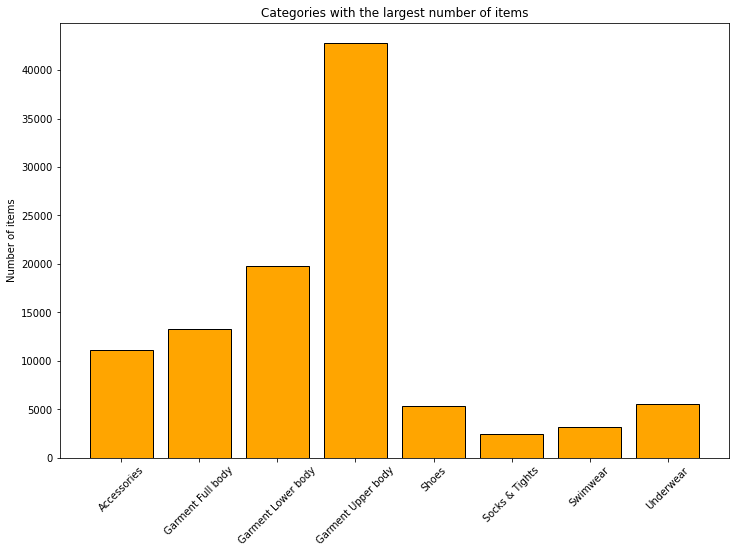

In [ ]:
plt.figure(figsize=(12, 8))
plt.bar(type_group['categories'], type_group['number_of_items'], color = "orange", edgecolor = "black")
plt.xticks(rotation = 45)
plt.title("Categories with the largest number of items")
plt.ylabel("Number of items")
plt.show()

Short conclusion: H&M sells 42741 items of **upper body** clothes, which is 40%  out of all selling items. It means that for this category **the diversity of items is the highest one.**
Top categories in terms of number of items: 
1. Garment Upper body	
2. Garment Lower body	
3. Garment Full body	

Tatyana's part

<BarContainer object of 7 artists>

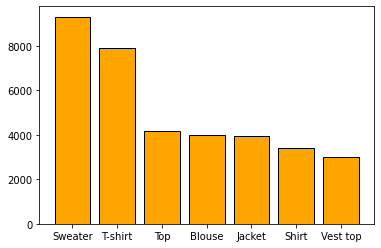

In [ ]:
# Now let's analyse what types of clothes is sold Top categories
# Garment Upper body 
articles_upper = articles.loc[articles['product_group_name'] == 'Garment Upper body']
type_upper = articles_upper.groupby(['product_type_name'], as_index = False).count().iloc[:,:2].sort_values(by=['article_id'], ascending=False)
type_upper.columns = ['Types', 'number_of_items']
plt.bar(type_upper.iloc[:7]['Types'], type_upper.iloc[:7]['number_of_items'], color = "orange", edgecolor = "black")


<BarContainer object of 5 artists>

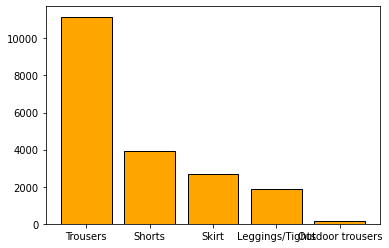

In [ ]:
# Garment Lower body 
articles_lower = articles.loc[articles['product_group_name'] == 'Garment Lower body']
type_lower = articles_lower.groupby(['product_type_name'], as_index = False).count().iloc[:,:2].sort_values(by=['article_id'], ascending=False)
type_lower.columns = ['Types', 'number_of_items']
plt.bar(type_lower.iloc[:7]['Types'], type_lower.iloc[:7]['number_of_items'], color = "orange", edgecolor = "black")


<BarContainer object of 5 artists>

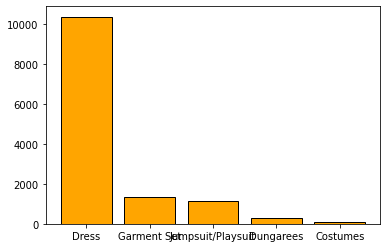

In [ ]:
#Garment Full body
articles_lower = articles.loc[articles['product_group_name'] == 'Garment Full body']
type_lower = articles_lower.groupby(['product_type_name'], as_index = False).count().iloc[:,:2].sort_values(by=['article_id'], ascending=False)
type_lower.columns = ['Types', 'number_of_items']
plt.bar(type_lower.iloc[:5]['Types'], type_lower.iloc[:5]['number_of_items'], color = "orange", edgecolor = "black")


# Customers
contribution: Kristina

In [ ]:
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


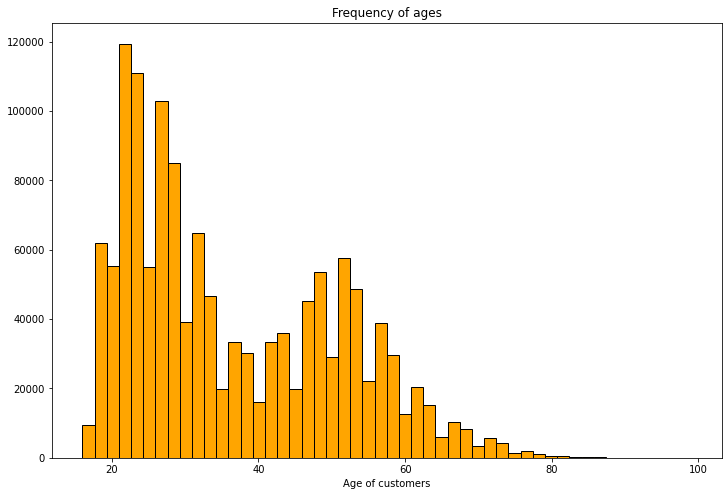

In [ ]:
plt.figure(figsize=(12, 8))
plt.hist(customers.age, edgecolor = 'black', color = 'orange', bins = 50);
plt.title("Frequency of ages")
plt.xlabel("Age of customers");

The histogram shows that the most nuber of purchases are made by people of 20-30 age years old

In [ ]:
member = customers.groupby(['club_member_status'], as_index = False).count()
y = customers.club_member_status.unique()

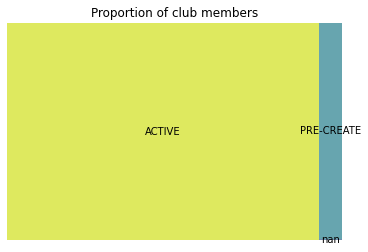

In [ ]:
squarify.plot(sizes = member.customer_id,
              label = y, alpha = 0.7)
plt.axis('off')
plt.title("Proportion of club members")
plt.show()

We have a large group of active club memebers. So, these types can have something like a recommendation system or special sales. Also it maybe mean that there is a significant part of regualar customers

In [ ]:
news = customers.groupby(['fashion_news_frequency'], as_index = False).count()
news = news[news['customer_id'] > 100]  # To avoid None that have 2 persons
y = news.fashion_news_frequency.unique()

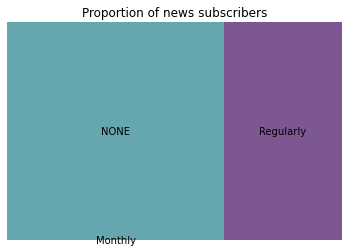

In [ ]:
squarify.plot(sizes = news.customer_id,
              label = y, alpha = 0.7)
plt.axis('off')
plt.title("Proportion of news subscribers")
plt.show()

Most part does not recieve recommendations from the cite and maybe potentially is not interested in recommendations

# Transactions
contribution: Kristina

In [ ]:
transactions.head(10)

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2
5,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687001,0.016932,2
6,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221001,0.020322,2
7,2018-09-20,00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4...,688873012,0.030492,1
8,2018-09-20,00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4...,501323011,0.053373,1
9,2018-09-20,00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4...,598859003,0.045746,2


In [ ]:
transactions.columns

Index(['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id'], dtype='object')

In [ ]:
mean_price = transactions.groupby(['t_dat', 'customer_id'], as_index = False)['price'].mean()
mean_price

KeyboardInterrupt: ignored

In [ ]:
plt.figure(figsize=(12, 8))
plt.hist(mean_price.price, edgecolor = 'black', color = 'orange', bins = 50, range = [0.0, 0.2]);
plt.title("Average price for purchase")
plt.xlabel("Price");  # Unfortunetly, there is no information about units

In [ ]:
mean_transactions = transactions.groupby(['t_dat', 'customer_id'], as_index = False)['article_id'].count()
mean_transactions.head(10)

,t_dat,customer_id,article_id
4540089,2019-09-07,69a9c5865987addc53e78e2eec1696da82da6ca94feff9...,1
4567472,2019-09-10,0b598764c77eeca6ef3434f032f4a37e6cd39c8567a704...,1
4567475,2019-09-10,0b5c3c30b5f894a7f5434de12bc7125da44329b27d86c8...,1
4567477,2019-09-10,0b6f638ebdc4ef23afda7b590cdb70fe0e67b2c495cf11...,1
4567479,2019-09-10,0b77cebd3408d6f42b9becfc96de4a5c0f969bad5c4122...,1
...,...,...,...
1869380,2019-02-16,94665b46e194622ccdbcadc0170f13a2f8ede1ff6d057d...,199
333665,2018-10-15,246734d8f4a4252fcd5c7aa525055a2804b9a6fb3d4210...,220
1489900,2019-01-13,62fd7d41b587c72a95c31eca5046019ce4e802853397ff...,221
1161741,2018-12-17,c2f0cdda2dc3042ccd9fcd8253fd8e368769840581e40a...,336


In [ ]:
# Average number of iteams, that a consumer buys
mean_transactions.article_id.mean()

On average, a customer buys 3-4 items

In [ ]:
plt.figure(figsize=(12, 8))
plt.hist(mean_transactions.article_id, edgecolor = 'black', color = 'orange', bins = 20, range = [0.0, 30]);
plt.xlabel("Number of purchases");
# Think how to cut the range of a histogram

In [ ]:
popular_items = transactions.groupby(['article_id'], as_index = False)['t_dat'].count()
top_items = popular_items.sort_values(['t_dat'], ascending = False)[:20]  # Top 20 items 
top_items = top_items.rename(columns = {"t_dat":"count"})

In [ ]:
result = pd.merge(top_items, articles, on = "article_id")
result  # We can just recommend customers to buy the most popular items

First of all we should prepare the data. We add some features from customers table to transactions_train data

In [ ]:
customers.columns

In [ ]:
customs = customers[['customer_id', 'club_member_status', 'fashion_news_frequency', 'age', 'postal_code']]

In [ ]:
customs.club_member_status.unique()

In [ ]:
customs.fashion_news_frequency.unique()

In [ ]:
# We have some categories that should be noted as 'not defined'
# However, we have some different combinations for this category in 'fashion_news_frequency'
# And 'nan' in 'club_member_status'

customs.club_member_status = customs.club_member_status.fillna(0)
customs.club_member_status = customs.club_member_status.replace(0, "NOT_DEF")

In [ ]:
customs.fashion_news_frequency = customs.fashion_news_frequency.fillna(0)
customs.fashion_news_frequency = customs.fashion_news_frequency.replace(['None', 0], 'NONE')

In [ ]:
customs = pd.get_dummies(customs, columns = ['fashion_news_frequency', 'club_member_status'], drop_first = True)

In [ ]:
customs

In [ ]:
transactions.columns

In [ ]:
transactions.describe()

In [ ]:
transactions.sort_values("customer_id")
customs.sort_values("customer_id")

In [ ]:
#res = pd.concat([customs, transactions], axis = 1, keys = 'customer_id', join = 'outer')
res = pd.merge(transactions, customs, on=['customer_id'], how='inner')

In [ ]:
res.head()

We tried to model KNN. However, because of memory lack we cannot receive results
Also, it is not a good method to desribe recommendations as a predicted variable is not specified correctly


# Dataset preparation
cotribution: Kristina



To simplify our data (problems with model estimation after downloads of files). We decide to model only for the most active users. So, let's try to produce another set of users

In [ ]:
# Set the top of popular items
most_transactions = transactions.groupby(["article_id"], as_index = False)["customer_id"].count()
most_transactions = most_transactions.rename(columns={"customer_id":"num_transactions"})
most_transactions = most_transactions.sort_values("num_transactions", ascending = False)
most_transactions.head(10)

,article_id,num_transactions
53832,706016001,50287
53833,706016002,35043
1711,372860001,31718
24808,610776002,30199
70124,759871002,26329
3706,464297007,25025
1712,372860002,24458
24807,610776001,22451
2233,399223001,22236
53834,706016003,21241


In [ ]:
most_transactions = most_transactions[:200]
# reduce the number to have an opportunity to evaluate the model

In [ ]:
most_transactions

,article_id,num_transactions
53832,706016001,50287
53833,706016002,35043
1711,372860001,31718
24808,610776002,30199
70124,759871002,26329
...,...,...
33831,640021005,6899
95131,866383001,6831
23478,605690001,6734
38575,658298001,6731


In [ ]:
transactions = transactions[transactions["article_id"].isin(most_transactions.article_id)].reset_index(drop=True)

In [ ]:
print("The number of unique items in a reduced set: ", len(transactions['article_id'].unique()))

The number of unique items in a reduced set:  200


In [ ]:
# Top of cutomers
most_customers = transactions.groupby(["t_dat","customer_id"], as_index = False)["article_id"].count()
most_customers = most_customers.rename(columns={"article_id":"num_transactions"})
most_customers = most_customers.sort_values("num_transactions", ascending = False)
most_customers = most_customers[most_customers['num_transactions'] > 10]
# This allows to delete customers who buy less than 11 items

In [ ]:
transactions = transactions[transactions["customer_id"].isin(most_customers.customer_id)].reset_index(drop=True)

In [ ]:
print("The number of unique customers in a reduced set: ", len(transactions['customer_id'].unique()))

The number of unique customers in a reduced set:  1255


In [ ]:
transactions

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,150e3d09b926dceebb85dddaf506feb6cdbad3c7c8c5e0...,539723001,0.031051,2
1,2018-09-20,150e3d09b926dceebb85dddaf506feb6cdbad3c7c8c5e0...,539723001,0.030932,2
2,2018-09-20,150e3d09b926dceebb85dddaf506feb6cdbad3c7c8c5e0...,539723001,0.031051,2
3,2018-09-20,415a635c833eca2e0525fd673f76015545ad46591e189e...,539723001,0.031271,1
4,2018-09-20,415a635c833eca2e0525fd673f76015545ad46591e189e...,539723005,0.031271,1
...,...,...,...,...,...
30058,2020-09-22,8ba1d5230da686f7eef745d7739f81aa9a55fd6bd9bd65...,673677002,0.025407,2
30059,2020-09-22,8ba1d5230da686f7eef745d7739f81aa9a55fd6bd9bd65...,673677002,0.025407,2
30060,2020-09-22,8ba1d5230da686f7eef745d7739f81aa9a55fd6bd9bd65...,673677002,0.025407,2
30061,2020-09-22,8ba1d5230da686f7eef745d7739f81aa9a55fd6bd9bd65...,673677002,0.025407,2


In [ ]:
new_trans = transactions

In [ ]:
new_trans.to_csv("/content/new_trans.csv")
# Create a new file that is less than previous
# You can also find it in google disk

# Kmeans
contribution: Tatyana

In [ ]:
#Selecting the most interesting columns(features are incoded)
article_col = articles[['article_id', 'product_code','product_type_no', 'graphical_appearance_no', 'colour_group_code', 
                     'perceived_colour_value_id', 'perceived_colour_master_id', 'department_no', 'index_group_no',
                     'section_no', 'garment_group_no']] 

In [ ]:
from sklearn.preprocessing import LabelEncoder
customers_col = customers[['customer_id', 'club_member_status', 'fashion_news_frequency', 'age']]

# Creating a instance of label Encoder.
le = LabelEncoder()
# Using .fit_transform function to fit label
# encoder and return encoded label
label1 = le.fit_transform(customers_col['club_member_status'])
customers_col.drop("club_member_status", axis=1, inplace=True)

# Appending the array to our dataFrame
# with column name 'Purchased'
customers_col["club_member_status"] = label1



label2 = le.fit_transform(customers_col['fashion_news_frequency'])
customers_col.drop("fashion_news_frequency", axis=1, inplace=True)
customers_col["fashion_news_frequency"] = label2
customers_col




/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

,customer_id,age,club_member_status,fashion_news_frequency
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,49.0,0,1
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,25.0,0,1
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,24.0,0,1
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,54.0,0,1
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,52.0,0,3
...,...,...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,24.0,0,1
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,21.0,0,1
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,21.0,0,3
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,18.0,0,3


In [ ]:
data1 = pd.merge(transactions,article_col, on = ['article_id'])
data2 = pd.merge(data1,customers_col, on = ['customer_id'])

In [ ]:
x = data2 [['product_code','product_type_no', 'graphical_appearance_no', 'colour_group_code', 
                     'perceived_colour_value_id', 'perceived_colour_master_id', 'index_group_no',
                     'section_no', 'garment_group_no', 'age', 'club_member_status','fashion_news_frequency' ]]

In [ ]:
xx = x.dropna()
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist 

rg = range(1, 20)
inertia = []
for k in rg: 
  kmeans = KMeans(n_clusters = k, random_state = 1).fit(X)
  inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(rg, inertia, marker = 's'); 
plt.xlabel('$k$')
plt.ylabel('$J(C)$')


# Recommendation System. Preparation

In [139]:
!pip install turicreate
import turicreate as tc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 92.0 MB 1.3 MB/s 
     |████████████████████████████████| 4.6 MB 63.6 MB/s 
     |████████████████████████████████| 3.6 MB 48.5 MB/s 
     |████████████████████████████████| 322 kB 77.8 MB/s 
     |████████████████████████████████| 18.3 MB 368 kB/s 
  Created wheel for prettytable: filename=prettytable-0.7.2-py3-none-any.whl size=13714 sha256=7127047fc2400df5d12d9d270a5af768f46db8cb9b048fe3adbfc8a7db6c2349
  Stored in directory: /root/.cache/pip/wheels/48/6d/77/9517cb933af254f51a446f1a5ec9c2be3e45f17384940bce68
  Created wheel for resampy: filename=resampy-0.2.1-py3-none-any.whl size=320859 sha256=9f9ee1c6eec7f59cebd38a9f4020501d4c904b06c657826c0103f6698e8003fe
  Stored in directory: /root/.cache/pip/wheels/2b/a9/15/89e0e4544c36f50e4e8d54d546f2331c461f505d3b55d3f358
Successfully built prettytable resampy
  Attempting uninstall: llvmlite
    Found ex

To analyze what we should recommend to customers we should understand what kind of items they find most appropriate. We need to scale each item from 0 to 1. For this purpose we will produce several tables


1.   Define how many times an item was bought by a customer
2.   Define what items were bought by a customer
3.   Normalize these purchases



In [133]:
new_trans = pd.read_csv("new_trans.csv")
train = new_trans.groupby(["customer_id","article_id"])["t_dat"].count().reset_index()
train = train.rename(columns={"t_dat":"purchase_count"})
train[50:70]

,customer_id,article_id,purchase_count
50,0193ecf5897f8ea030012a4b5142c99139db58a410b1e7...,108775015,3
51,0193ecf5897f8ea030012a4b5142c99139db58a410b1e7...,179950001,1
52,0193ecf5897f8ea030012a4b5142c99139db58a410b1e7...,464297007,2
53,0193ecf5897f8ea030012a4b5142c99139db58a410b1e7...,507909001,1
54,0193ecf5897f8ea030012a4b5142c99139db58a410b1e7...,579302001,1
55,0193ecf5897f8ea030012a4b5142c99139db58a410b1e7...,590928001,1
56,0193ecf5897f8ea030012a4b5142c99139db58a410b1e7...,599580017,3
57,0193ecf5897f8ea030012a4b5142c99139db58a410b1e7...,599580020,2
58,0193ecf5897f8ea030012a4b5142c99139db58a410b1e7...,610776001,1
59,0193ecf5897f8ea030012a4b5142c99139db58a410b1e7...,610776002,1


An example what it looks like. We will use another method to scale as a matriz is too big

In [134]:
df_matrix = pd.pivot_table(train, values='purchase_count', index='customer_id', columns='article_id')
df_matrix.head(6)

article_id,108775015,108775044,111586001,111593001,156231001,158340001,160442007,160442010,179123001,179950001,...,796210001,799365002,803757001,806388001,806388002,806388003,841383002,841383003,850917001,866383001
customer_id,,,,,,,,,,,,,,,,,,,,,
00750c6950d9a61ee44ed4520ef7262841a2e497956874e39136526163f34524,NaN,NaN,NaN,NaN,NaN,21.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00847ed06bb8bd9e10108eedc2757efd9d2871870314f1574d2ee23c342d1583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
008fdadc3b5a58957554f466266bd9e601867b76b6a5067c462331d2807c1e3f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
009a108ccf2356ced0561494ed3ef3597f7f75e1150c58bc63e45c2059cdaf16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN
009db236b68cde5b1005d66332f96d86d075e57fe6c3c9867bb4374a851cfac0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00f3cf84e96a1c17c0bf0806926c6d8b6b024c6d43a8545e3c9c9fea6a0ed37b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [135]:
df_matrix_norm = (df_matrix-df_matrix.min())/(df_matrix.max()-df_matrix.min())
df_matrix_norm.head(6)

article_id,108775015,108775044,111586001,111593001,156231001,158340001,160442007,160442010,179123001,179950001,...,796210001,799365002,803757001,806388001,806388002,806388003,841383002,841383003,850917001,866383001
customer_id,,,,,,,,,,,,,,,,,,,,,
00750c6950d9a61ee44ed4520ef7262841a2e497956874e39136526163f34524,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00847ed06bb8bd9e10108eedc2757efd9d2871870314f1574d2ee23c342d1583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
008fdadc3b5a58957554f466266bd9e601867b76b6a5067c462331d2807c1e3f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
009a108ccf2356ced0561494ed3ef3597f7f75e1150c58bc63e45c2059cdaf16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.130435,NaN,NaN,NaN
009db236b68cde5b1005d66332f96d86d075e57fe6c3c9867bb4374a851cfac0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00f3cf84e96a1c17c0bf0806926c6d8b6b024c6d43a8545e3c9c9fea6a0ed37b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [136]:
d = df_matrix_norm.reset_index()
d.index.names = ['scaled_purchase_freq']
data_norm = pd.melt(d, id_vars=['customer_id'], value_name='scaled_purchase_freq').dropna()
data_norm

,customer_id,article_id,scaled_purchase_freq
137,17a24088bfabda1ba8748f25b0a7564f41350941ddf87e...,108775015,0.461538
153,19ecf2a8d5bd35fcdbf40f92a593403fbd78a9567049d4...,108775015,0.230769
192,20852813d0fb957b31bbc28b663b3ec6873a22760d9176...,108775015,0.307692
200,21dc541f04d2e07c098fe65c6d5de0c585dd9c15a338ca...,108775015,0.384615
246,2978e892483fe98de2a753f2e134a1dfa072594a81bb7d...,108775015,0.307692
250,29e2a3ecff264c4c3dfad1f5d24046de1c1f71f01eb851...,108775015,0.230769
282,3018b87674288984445da2ccbb2371e66e5e16d5210abf...,108775015,0.384615
288,317dbe35f2338d5b07861bb1ac4914958170dfc4d9c870...,108775015,0.230769
299,33b183c597426013003a2fcce66da4722b8596a3a37331...,108775015,0.538462
306,34ca4c4cf3587299b1dc9f782d9f76df1233abb0cb13e3...,108775015,0.000000


### Split the data

In [140]:
# We will use two data splits and train according to these modifications
train, test = train_test_split(train, test_size = .2)
train_data = tc.SFrame(train)
test_data = tc.SFrame(test)

train_norm, test_norm = train_test_split(data_norm, test_size = .2)
train_data_norm = tc.SFrame(train_norm)
test_data_norm = tc.SFrame(test_norm)

### Baseline Model (the same recommendation for all)

In [141]:
# First one is to use "purchase_count"
# So, we will analyze what is the most popular item among customers

# variables to define field names
user_id = 'customer_id'
item_id = 'article_id'
target = 'purchase_count'
users_to_recommend = list(train[user_id])
n_rec = 12 # number of items to recommend according to 'sample_submission' file
n_display = 30 

In [ ]:
popularity_model = tc.popularity_recommender.create(train_data, 
                                                    user_id=user_id, 
                                                    item_id=item_id, 
                                                    target=target)

In [ ]:
# Second one is about normalized data

target = 'scaled_purchase_freq'
pop_norm_model = tc.popularity_recommender.create(train_data_norm, 
                                                    user_id=user_id, 
                                                    item_id=item_id, 
                                                    target=target)

###Results

In [ ]:
popularity_recomm = popularity_model.recommend(users=users_to_recommend, k=n_rec)
popularity_recomm.print_rows(n_display)

According to results of this model we can recommend the most popular (most freaquently bought) items among all consumers 

In [ ]:
articles[(articles["article_id" ] == 507909003) | (articles["article_id" ] == 399087014) | (articles["article_id" ] == 685813001)  | (articles["article_id" ] == 561445005)]

One of the disadvantage of this method is that we do not personalize our recommendations. So, items are the same for all customers. Second is that according to our data cuts we throw away a lot of observations. However, it is the model with simpliest equations and our baseline

In [ ]:
regularization_recomm = pop_norm_model.recommend(users=users_to_recommend, k=n_rec)
regularization_recomm.print_rows(n_display)

The results are again the same for all customers. But we have different recommendations, because in the case of normalization we do not take into account the frequency of purchases. 

In purchase_count the most popular items more probably are from customers who are the most active. In scaled_purchase_freq we have scale this situaiton and just compare the normalize score

In [ ]:
articles[(articles["article_id" ] == 573085043) | (articles["article_id" ] == 783346018) | (articles["article_id" ] == 655784001)  | (articles["article_id" ] == 866383001)]

# Collaborative Filtering Model

Here we repeat the idea to find similar customers according their purchases and recommend items that they haven't bought yet

To realize this idea we will construct the similarity matrix (according to cosine similarity)

MAYBE ALSO USE Alternative Least Squares algorithm (ALS)

In [ ]:
# Again start from the purchase count
target = 'purchase_count'
count_pears = tc.item_similarity_recommender.create(train_data, 
                                                    user_id=user_id, 
                                                    item_id=item_id, 
                                                    target=target, 
                                                    similarity_type='cosine')
        
count_recom = count_pears.recommend(users=users_to_recommend, k=n_rec)
count_recom.print_rows(n_display)

I have alsotriedd to use pearson similarity. But the results are not so heterogenious and all users have nearly the same recommendations

In [ ]:
# And then take a look on the normalized data
target = 'scaled_purchase_freq'
count_pears_norm = tc.item_similarity_recommender.create(train_data_norm, 
                                                    user_id=user_id, 
                                                    item_id=item_id, 
                                                    target=target, 
                                                    similarity_type='cosine')
        
recom = count_pears_norm.recommend(users=users_to_recommend, k=n_rec)
recom.print_rows(n_display)

### Model Evaluation

We will use
- RMSE
- Precision
- Recall

In [186]:
models = [popularity_model, count_pears]
names = ["Baseline Purchase count model", "Filttering model with Purchase count"]

In [187]:
eval_counts = tc.recommender.util.compare_models(test_data, models, model_names=names)

PROGRESS: Evaluate model Baseline Purchase count model

Precision and recall summary statistics by cutoff
+--------+----------------------+----------------------+
| cutoff |    mean_precision    |     mean_recall      |
+--------+----------------------+----------------------+
|   1    | 0.014084507042253527 | 0.013380281690140848 |
|   2    | 0.009154929577464787 | 0.015375586854460095 |
|   3    | 0.01032863849765258  | 0.023591549295774655 |
|   4    | 0.01161971830985916  | 0.03368544600938968  |
|   5    | 0.010704225352112684 | 0.03787726358148895  |
|   6    | 0.011737089201877937 | 0.04989604292421196  |
|   7    | 0.012072434607645878 | 0.05963782696177062  |
|   8    | 0.011971830985915493 | 0.06660965794768611  |
|   9    | 0.011424100156494517 | 0.07165660630449364  |
|   10   | 0.010563380281690144 | 0.07376928236083166  |
+--------+----------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 5.001762022614471

Per User RMSE (best)
+-----------------

In [184]:
models = [pop_norm_model, count_pears_norm]
names = ["Baseline Purchase normalization model", "Filttering model with Purchase normalization"]

In [185]:
eval_counts = tc.recommender.util.compare_models(test_data_norm, models, model_names=names)

PROGRESS: Evaluate model Baseline Purchase normalization model

Precision and recall summary statistics by cutoff
+--------+-----------------------+-----------------------+
| cutoff |     mean_precision    |      mean_recall      |
+--------+-----------------------+-----------------------+
|   1    | 0.0025348542458808617 | 0.0016899028305872414 |
|   2    |  0.008871989860583018 |  0.009442332065906212 |
|   3    |  0.008449514152936207 |  0.012970004224757083 |
|   4    | 0.0076045627376425855 |  0.01438529784537389  |
|   5    |  0.008111533586818763 |  0.01854668356569497  |
|   6    |  0.008027038445289403 |  0.02072243346007605  |
|   7    |  0.009053050878145941 |  0.02877059569074778  |
|   8    |  0.009980988593155894 |  0.036375158428390356 |
|   9    |  0.009857766511758896 |  0.040536544148711454 |
|   10   |  0.009505703422053225 |   0.0456062526404732  |
+--------+-----------------------+-----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.22101851442647

Per 

According to RMSE we should choose the last evaluated model: normalized purchases according to cosine similarity. However, we have very bad precision and recall

### Prediction

In [189]:
users_to_recommend = list(customers[user_id])
n_rec = 12

final_model = tc.item_similarity_recommender.create(tc.SFrame(data_norm), 
                                            user_id=user_id, 
                                            item_id=item_id, 
                                            target='scaled_purchase_freq', 
                                            similarity_type='cosine')

recom = final_model.recommend(users=users_to_recommend, k=n_rec)
recom.print_rows(n_display)

Preparing data set.

Data has 8025 observations with 1255 users and 200 items.

Data prepared in: 0.028586s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.058ms                        | 79.5       |

| 1.22ms                         | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 1.552ms                             | 0.5              | 1               |

| 5.711ms                             | 100              | 200             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.011668s

recommendations finished on 1000/1371980 queries. users per second: 73621.4

recommendations finished on 2000/1371980 queries. users per second: 64139.6

recommendations finished on 3000/1371980 queries. users per second: 61855.7

recommendations finished on 4000/1371980 queries. users per second: 61292.3

recommendations finished on 5000/1371980 queries. users per second: 59781.4

recommendations finished on 6000/1371980 queries. users per second: 60190.2

recommendations finished on 7000/1371980 queries. users per second: 59106.6

recommendations finished on 8000/1371980 queries. users per second: 58771.2

recommendations finished on 9000/1371980 queries. users per second: 59223.4

recommendations finished on 10000/1371980 queries. users per second: 59102

recommendations finished on 11000/1371980 queries. users per second: 59309.7

recommendations finished on 12000/1371980 queries. users per second: 59233.5

recommendations finished on 13000/1371980 queries. users per second: 59104.1

recommendations finished on 14000/1371980 queries. users per second: 59075.2

recommendations finished on 15000/1371980 queries. users per second: 58850.3

recommendations finished on 16000/1371980 queries. users per second: 57808.5

recommendations finished on 17000/1371980 queries. users per second: 56699.4

recommendations finished on 18000/1371980 queries. users per second: 56729

recommendations finished on 19000/1371980 queries. users per second: 57012.5

recommendations finished on 20000/1371980 queries. users per second: 57003.3

recommendations finished on 21000/1371980 queries. users per second: 57022.1

recommendations finished on 22000/1371980 queries. users per second: 57336.6

recommendations finished on 23000/1371980 queries. users per second: 57046.3

recommendations finished on 24000/1371980 queries. users per second: 57325.8

recommendations finished on 25000/1371980 queries. users per second: 56711.3

recommendations finished on 26000/1371980 queries. users per second: 56887.6

recommendations finished on 27000/1371980 queries. users per second: 56538.7

recommendations finished on 28000/1371980 queries. users per second: 56606.3

recommendations finished on 29000/1371980 queries. users per second: 56576.2

recommendations finished on 30000/1371980 queries. users per second: 56672.1

recommendations finished on 31000/1371980 queries. users per second: 56752

recommendations finished on 32000/1371980 queries. users per second: 56846.4

recommendations finished on 33000/1371980 queries. users per second: 56820.9

recommendations finished on 34000/1371980 queries. users per second: 56973.9

recommendations finished on 35000/1371980 queries. users per second: 56285.6

recommendations finished on 36000/1371980 queries. users per second: 56374.5

recommendations finished on 37000/1371980 queries. users per second: 56505

recommendations finished on 38000/1371980 queries. users per second: 56503.7

recommendations finished on 39000/1371980 queries. users per second: 56634.8

recommendations finished on 40000/1371980 queries. users per second: 56265.8

recommendations finished on 41000/1371980 queries. users per second: 56097.8

recommendations finished on 42000/1371980 queries. users per second: 55963.7

recommendations finished on 43000/1371980 queries. users per second: 55952.6

recommendations finished on 44000/1371980 queries. users per second: 55959.6

recommendations finished on 45000/1371980 queries. users per second: 56117.6

recommendations finished on 46000/1371980 queries. users per second: 56069.7

recommendations finished on 47000/1371980 queries. users per second: 56219.9

recommendations finished on 48000/1371980 queries. users per second: 56343.3

recommendations finished on 49000/1371980 queries. users per second: 56102.3

recommendations finished on 50000/1371980 queries. users per second: 56122

recommendations finished on 51000/1371980 queries. users per second: 55959.2

recommendations finished on 52000/1371980 queries. users per second: 56073.9

recommendations finished on 53000/1371980 queries. users per second: 55973.4

recommendations finished on 54000/1371980 queries. users per second: 56083.7

recommendations finished on 55000/1371980 queries. users per second: 56057.1

recommendations finished on 56000/1371980 queries. users per second: 55807.2

recommendations finished on 57000/1371980 queries. users per second: 55851.3

recommendations finished on 58000/1371980 queries. users per second: 55923.1

recommendations finished on 59000/1371980 queries. users per second: 55964.2

recommendations finished on 60000/1371980 queries. users per second: 56019

recommendations finished on 61000/1371980 queries. users per second: 56150.7

recommendations finished on 62000/1371980 queries. users per second: 56083.3

recommendations finished on 63000/1371980 queries. users per second: 56095.3

recommendations finished on 64000/1371980 queries. users per second: 56160.9

recommendations finished on 65000/1371980 queries. users per second: 56174.4

recommendations finished on 66000/1371980 queries. users per second: 56237.3

recommendations finished on 67000/1371980 queries. users per second: 56322.9

recommendations finished on 68000/1371980 queries. users per second: 56293.3

recommendations finished on 69000/1371980 queries. users per second: 56329.3

recommendations finished on 70000/1371980 queries. users per second: 56235.7

recommendations finished on 71000/1371980 queries. users per second: 56294.8

recommendations finished on 72000/1371980 queries. users per second: 56266.7

recommendations finished on 73000/1371980 queries. users per second: 56293.9

recommendations finished on 74000/1371980 queries. users per second: 56273.6

recommendations finished on 75000/1371980 queries. users per second: 56350.8

recommendations finished on 76000/1371980 queries. users per second: 56267.2

recommendations finished on 77000/1371980 queries. users per second: 56228.2

recommendations finished on 78000/1371980 queries. users per second: 56195.8

recommendations finished on 79000/1371980 queries. users per second: 56274.1

recommendations finished on 80000/1371980 queries. users per second: 56352.3

recommendations finished on 81000/1371980 queries. users per second: 56312.5

recommendations finished on 82000/1371980 queries. users per second: 56395.9

recommendations finished on 83000/1371980 queries. users per second: 56312.6

recommendations finished on 84000/1371980 queries. users per second: 56281.7

recommendations finished on 85000/1371980 queries. users per second: 56263.4

recommendations finished on 86000/1371980 queries. users per second: 56342.1

recommendations finished on 87000/1371980 queries. users per second: 56190

recommendations finished on 88000/1371980 queries. users per second: 56220.2

recommendations finished on 89000/1371980 queries. users per second: 56025.8

recommendations finished on 90000/1371980 queries. users per second: 55999.6

recommendations finished on 91000/1371980 queries. users per second: 55986.9

recommendations finished on 92000/1371980 queries. users per second: 55794.5

recommendations finished on 93000/1371980 queries. users per second: 55827.2

recommendations finished on 94000/1371980 queries. users per second: 55895.6

recommendations finished on 95000/1371980 queries. users per second: 55859.8

recommendations finished on 96000/1371980 queries. users per second: 55932

recommendations finished on 97000/1371980 queries. users per second: 55990.2

recommendations finished on 98000/1371980 queries. users per second: 55831.7

recommendations finished on 99000/1371980 queries. users per second: 55861

recommendations finished on 100000/1371980 queries. users per second: 55879.4

recommendations finished on 101000/1371980 queries. users per second: 55881.8

recommendations finished on 102000/1371980 queries. users per second: 55930.8

recommendations finished on 103000/1371980 queries. users per second: 56010.8

recommendations finished on 104000/1371980 queries. users per second: 55968.5

recommendations finished on 105000/1371980 queries. users per second: 56044.7

recommendations finished on 106000/1371980 queries. users per second: 55994.2

recommendations finished on 107000/1371980 queries. users per second: 55926

recommendations finished on 108000/1371980 queries. users per second: 55888.4

recommendations finished on 109000/1371980 queries. users per second: 55922.4

recommendations finished on 110000/1371980 queries. users per second: 55922.6

recommendations finished on 111000/1371980 queries. users per second: 55988.8

recommendations finished on 112000/1371980 queries. users per second: 55964.1

recommendations finished on 113000/1371980 queries. users per second: 56009.4

recommendations finished on 114000/1371980 queries. users per second: 56057.6

recommendations finished on 115000/1371980 queries. users per second: 56033.1

recommendations finished on 116000/1371980 queries. users per second: 56082.2

recommendations finished on 117000/1371980 queries. users per second: 56030.5

recommendations finished on 118000/1371980 queries. users per second: 56072.7

recommendations finished on 119000/1371980 queries. users per second: 55952.4

recommendations finished on 120000/1371980 queries. users per second: 55990.7

recommendations finished on 121000/1371980 queries. users per second: 55981.4

recommendations finished on 122000/1371980 queries. users per second: 56027.1

recommendations finished on 123000/1371980 queries. users per second: 56024.6

recommendations finished on 124000/1371980 queries. users per second: 55999.4

recommendations finished on 125000/1371980 queries. users per second: 56029.5

recommendations finished on 126000/1371980 queries. users per second: 55964.1

recommendations finished on 127000/1371980 queries. users per second: 56022.7

recommendations finished on 128000/1371980 queries. users per second: 55989.6

recommendations finished on 129000/1371980 queries. users per second: 56047.7

recommendations finished on 130000/1371980 queries. users per second: 55943.4

recommendations finished on 131000/1371980 queries. users per second: 55968.3

recommendations finished on 132000/1371980 queries. users per second: 55927.5

recommendations finished on 133000/1371980 queries. users per second: 55842.2

recommendations finished on 134000/1371980 queries. users per second: 55834.8

recommendations finished on 135000/1371980 queries. users per second: 55897.2

recommendations finished on 136000/1371980 queries. users per second: 55876

recommendations finished on 137000/1371980 queries. users per second: 55784.5

recommendations finished on 138000/1371980 queries. users per second: 55724.2

recommendations finished on 139000/1371980 queries. users per second: 55750.2

recommendations finished on 140000/1371980 queries. users per second: 55754.4

recommendations finished on 141000/1371980 queries. users per second: 55804.2

recommendations finished on 142000/1371980 queries. users per second: 55780.2

recommendations finished on 143000/1371980 queries. users per second: 55831.2

recommendations finished on 144000/1371980 queries. users per second: 55851.8

recommendations finished on 145000/1371980 queries. users per second: 55836.8

recommendations finished on 146000/1371980 queries. users per second: 55874.7

recommendations finished on 147000/1371980 queries. users per second: 55775.1

recommendations finished on 148000/1371980 queries. users per second: 55732.6

recommendations finished on 149000/1371980 queries. users per second: 55641.5

recommendations finished on 150000/1371980 queries. users per second: 55687

recommendations finished on 151000/1371980 queries. users per second: 55678.5

recommendations finished on 152000/1371980 queries. users per second: 55699.5

recommendations finished on 153000/1371980 queries. users per second: 55709.3

recommendations finished on 154000/1371980 queries. users per second: 55688.2

recommendations finished on 155000/1371980 queries. users per second: 55704.4

recommendations finished on 156000/1371980 queries. users per second: 55599

recommendations finished on 157000/1371980 queries. users per second: 55616.8

recommendations finished on 158000/1371980 queries. users per second: 55551.2

recommendations finished on 159000/1371980 queries. users per second: 55528.8

recommendations finished on 160000/1371980 queries. users per second: 55537

recommendations finished on 161000/1371980 queries. users per second: 55513.5

recommendations finished on 162000/1371980 queries. users per second: 55542.9

recommendations finished on 163000/1371980 queries. users per second: 55495.5

recommendations finished on 164000/1371980 queries. users per second: 55518.3

recommendations finished on 165000/1371980 queries. users per second: 55542.9

recommendations finished on 166000/1371980 queries. users per second: 55430.9

recommendations finished on 167000/1371980 queries. users per second: 55457.1

recommendations finished on 168000/1371980 queries. users per second: 55454.8

recommendations finished on 169000/1371980 queries. users per second: 55485.1

recommendations finished on 170000/1371980 queries. users per second: 55453.4

recommendations finished on 171000/1371980 queries. users per second: 55468.6

recommendations finished on 172000/1371980 queries. users per second: 55438.5

recommendations finished on 173000/1371980 queries. users per second: 55445.5

recommendations finished on 174000/1371980 queries. users per second: 55430.1

recommendations finished on 175000/1371980 queries. users per second: 55454.9

recommendations finished on 176000/1371980 queries. users per second: 55300.1

recommendations finished on 177000/1371980 queries. users per second: 55325.6

recommendations finished on 178000/1371980 queries. users per second: 55266.3

recommendations finished on 179000/1371980 queries. users per second: 55313.2

recommendations finished on 180000/1371980 queries. users per second: 55296.8

recommendations finished on 181000/1371980 queries. users per second: 55331.2

recommendations finished on 182000/1371980 queries. users per second: 55368.7

recommendations finished on 183000/1371980 queries. users per second: 55321.9

recommendations finished on 184000/1371980 queries. users per second: 55363.1

recommendations finished on 185000/1371980 queries. users per second: 55313.5

recommendations finished on 186000/1371980 queries. users per second: 55345.2

recommendations finished on 187000/1371980 queries. users per second: 55320.3

recommendations finished on 188000/1371980 queries. users per second: 55340.8

recommendations finished on 189000/1371980 queries. users per second: 55312.5

recommendations finished on 190000/1371980 queries. users per second: 55337.6

recommendations finished on 191000/1371980 queries. users per second: 55313.3

recommendations finished on 192000/1371980 queries. users per second: 55348.8

recommendations finished on 193000/1371980 queries. users per second: 55308.7

recommendations finished on 194000/1371980 queries. users per second: 55334.3

recommendations finished on 195000/1371980 queries. users per second: 55360.9

recommendations finished on 196000/1371980 queries. users per second: 55353.5

recommendations finished on 197000/1371980 queries. users per second: 55412.9

recommendations finished on 198000/1371980 queries. users per second: 55325.8

recommendations finished on 199000/1371980 queries. users per second: 55345.1

recommendations finished on 200000/1371980 queries. users per second: 55346.5

recommendations finished on 201000/1371980 queries. users per second: 55367.4

recommendations finished on 202000/1371980 queries. users per second: 55377.7

recommendations finished on 203000/1371980 queries. users per second: 55424.1

recommendations finished on 204000/1371980 queries. users per second: 55335.8

recommendations finished on 205000/1371980 queries. users per second: 55372.4

recommendations finished on 206000/1371980 queries. users per second: 55355.3

recommendations finished on 207000/1371980 queries. users per second: 55361.6

recommendations finished on 208000/1371980 queries. users per second: 55395.5

recommendations finished on 209000/1371980 queries. users per second: 55354.6

recommendations finished on 210000/1371980 queries. users per second: 55383.7

recommendations finished on 211000/1371980 queries. users per second: 55342.3

recommendations finished on 212000/1371980 queries. users per second: 55369

recommendations finished on 213000/1371980 queries. users per second: 55286

recommendations finished on 214000/1371980 queries. users per second: 55259.4

recommendations finished on 215000/1371980 queries. users per second: 55182.1

recommendations finished on 216000/1371980 queries. users per second: 55141.2

recommendations finished on 217000/1371980 queries. users per second: 55168.9

recommendations finished on 218000/1371980 queries. users per second: 55068.4

recommendations finished on 219000/1371980 queries. users per second: 55088.3

recommendations finished on 220000/1371980 queries. users per second: 55067.9

recommendations finished on 221000/1371980 queries. users per second: 55097

recommendations finished on 222000/1371980 queries. users per second: 55056.7

recommendations finished on 223000/1371980 queries. users per second: 55051.2

recommendations finished on 224000/1371980 queries. users per second: 55029.3

recommendations finished on 225000/1371980 queries. users per second: 55068.9

recommendations finished on 226000/1371980 queries. users per second: 55027.9

recommendations finished on 227000/1371980 queries. users per second: 55010.6

recommendations finished on 228000/1371980 queries. users per second: 54997.5

recommendations finished on 229000/1371980 queries. users per second: 55026.5

recommendations finished on 230000/1371980 queries. users per second: 55057.1

recommendations finished on 231000/1371980 queries. users per second: 55043.4

recommendations finished on 232000/1371980 queries. users per second: 55078

recommendations finished on 233000/1371980 queries. users per second: 55062.4

recommendations finished on 234000/1371980 queries. users per second: 55063.1

recommendations finished on 235000/1371980 queries. users per second: 55070.7

recommendations finished on 236000/1371980 queries. users per second: 55030.6

recommendations finished on 237000/1371980 queries. users per second: 55037.7

recommendations finished on 238000/1371980 queries. users per second: 55022.3

recommendations finished on 239000/1371980 queries. users per second: 55008.9

recommendations finished on 240000/1371980 queries. users per second: 54920

recommendations finished on 241000/1371980 queries. users per second: 54891.8

recommendations finished on 242000/1371980 queries. users per second: 54882.7

recommendations finished on 243000/1371980 queries. users per second: 54883.9

recommendations finished on 244000/1371980 queries. users per second: 54900.4

recommendations finished on 245000/1371980 queries. users per second: 54861.6

recommendations finished on 246000/1371980 queries. users per second: 54860.8

recommendations finished on 247000/1371980 queries. users per second: 54842

recommendations finished on 248000/1371980 queries. users per second: 54867.1

recommendations finished on 249000/1371980 queries. users per second: 54894.5

recommendations finished on 250000/1371980 queries. users per second: 54838.3

recommendations finished on 251000/1371980 queries. users per second: 54807.3

recommendations finished on 252000/1371980 queries. users per second: 54834.7

recommendations finished on 253000/1371980 queries. users per second: 54817.5

recommendations finished on 254000/1371980 queries. users per second: 54854.4

recommendations finished on 255000/1371980 queries. users per second: 54828.8

recommendations finished on 256000/1371980 queries. users per second: 54846.8

recommendations finished on 257000/1371980 queries. users per second: 54866.8

recommendations finished on 258000/1371980 queries. users per second: 54779.4

recommendations finished on 259000/1371980 queries. users per second: 54644.9

recommendations finished on 260000/1371980 queries. users per second: 54671.1

recommendations finished on 261000/1371980 queries. users per second: 54652.9

recommendations finished on 262000/1371980 queries. users per second: 54682.4

recommendations finished on 263000/1371980 queries. users per second: 54710.1

recommendations finished on 264000/1371980 queries. users per second: 54692.1

recommendations finished on 265000/1371980 queries. users per second: 54725.5

recommendations finished on 266000/1371980 queries. users per second: 54662.9

recommendations finished on 267000/1371980 queries. users per second: 54674.8

recommendations finished on 268000/1371980 queries. users per second: 54641.3

recommendations finished on 269000/1371980 queries. users per second: 54565.1

recommendations finished on 270000/1371980 queries. users per second: 54570.6

recommendations finished on 271000/1371980 queries. users per second: 54594.9

recommendations finished on 272000/1371980 queries. users per second: 54572.5

recommendations finished on 273000/1371980 queries. users per second: 54603.5

recommendations finished on 274000/1371980 queries. users per second: 54598.7

recommendations finished on 275000/1371980 queries. users per second: 54542.8

recommendations finished on 276000/1371980 queries. users per second: 54535

recommendations finished on 277000/1371980 queries. users per second: 54549.7

recommendations finished on 278000/1371980 queries. users per second: 54576

recommendations finished on 279000/1371980 queries. users per second: 54513.7

recommendations finished on 280000/1371980 queries. users per second: 54486.1

recommendations finished on 281000/1371980 queries. users per second: 54484.2

recommendations finished on 282000/1371980 queries. users per second: 54500

recommendations finished on 283000/1371980 queries. users per second: 54488.9

recommendations finished on 284000/1371980 queries. users per second: 54507.2

recommendations finished on 285000/1371980 queries. users per second: 54513.3

recommendations finished on 286000/1371980 queries. users per second: 54494

recommendations finished on 287000/1371980 queries. users per second: 54497.6

recommendations finished on 288000/1371980 queries. users per second: 54451.1

recommendations finished on 289000/1371980 queries. users per second: 54454.9

recommendations finished on 290000/1371980 queries. users per second: 54470.9

recommendations finished on 291000/1371980 queries. users per second: 54437.7

recommendations finished on 292000/1371980 queries. users per second: 54452.5

recommendations finished on 293000/1371980 queries. users per second: 54440.9

recommendations finished on 294000/1371980 queries. users per second: 54422.4

recommendations finished on 295000/1371980 queries. users per second: 54428.1

recommendations finished on 296000/1371980 queries. users per second: 54413.6

recommendations finished on 297000/1371980 queries. users per second: 54437.2

recommendations finished on 298000/1371980 queries. users per second: 54399.9

recommendations finished on 299000/1371980 queries. users per second: 54421.9

recommendations finished on 300000/1371980 queries. users per second: 54382.5

recommendations finished on 301000/1371980 queries. users per second: 54372.7

recommendations finished on 302000/1371980 queries. users per second: 54325.8

recommendations finished on 303000/1371980 queries. users per second: 54350.9

recommendations finished on 304000/1371980 queries. users per second: 54336.4

recommendations finished on 305000/1371980 queries. users per second: 54361.3

recommendations finished on 306000/1371980 queries. users per second: 54338.2

recommendations finished on 307000/1371980 queries. users per second: 54354.5

recommendations finished on 308000/1371980 queries. users per second: 54364.6

recommendations finished on 309000/1371980 queries. users per second: 54355

recommendations finished on 310000/1371980 queries. users per second: 54379.6

recommendations finished on 311000/1371980 queries. users per second: 54277

recommendations finished on 312000/1371980 queries. users per second: 54222.8

recommendations finished on 313000/1371980 queries. users per second: 54203.9

recommendations finished on 314000/1371980 queries. users per second: 54145.4

recommendations finished on 315000/1371980 queries. users per second: 54151.1

recommendations finished on 316000/1371980 queries. users per second: 54144.8

recommendations finished on 317000/1371980 queries. users per second: 54166.4

recommendations finished on 318000/1371980 queries. users per second: 54128.7

recommendations finished on 319000/1371980 queries. users per second: 54108.2

recommendations finished on 320000/1371980 queries. users per second: 54092.1

recommendations finished on 321000/1371980 queries. users per second: 54091.8

recommendations finished on 322000/1371980 queries. users per second: 54073.1

recommendations finished on 323000/1371980 queries. users per second: 54096.7

recommendations finished on 324000/1371980 queries. users per second: 54080

recommendations finished on 325000/1371980 queries. users per second: 54104.1

recommendations finished on 326000/1371980 queries. users per second: 54090.2

recommendations finished on 327000/1371980 queries. users per second: 54061.7

recommendations finished on 328000/1371980 queries. users per second: 54059.5

recommendations finished on 329000/1371980 queries. users per second: 54080.5

recommendations finished on 330000/1371980 queries. users per second: 54009.9

recommendations finished on 331000/1371980 queries. users per second: 54021.2

recommendations finished on 332000/1371980 queries. users per second: 53992.7

recommendations finished on 333000/1371980 queries. users per second: 54006.8

recommendations finished on 334000/1371980 queries. users per second: 53994

recommendations finished on 335000/1371980 queries. users per second: 54010.3

recommendations finished on 336000/1371980 queries. users per second: 54019.9

recommendations finished on 337000/1371980 queries. users per second: 53979.2

recommendations finished on 338000/1371980 queries. users per second: 53962.5

recommendations finished on 339000/1371980 queries. users per second: 53984.7

recommendations finished on 340000/1371980 queries. users per second: 53940.3

recommendations finished on 341000/1371980 queries. users per second: 53967.8

recommendations finished on 342000/1371980 queries. users per second: 53906.9

recommendations finished on 343000/1371980 queries. users per second: 53934.6

recommendations finished on 344000/1371980 queries. users per second: 53907.5

recommendations finished on 345000/1371980 queries. users per second: 53925.5

recommendations finished on 346000/1371980 queries. users per second: 53912.7

recommendations finished on 347000/1371980 queries. users per second: 53910

recommendations finished on 348000/1371980 queries. users per second: 53910.5

recommendations finished on 349000/1371980 queries. users per second: 53848

recommendations finished on 350000/1371980 queries. users per second: 53840.6

recommendations finished on 351000/1371980 queries. users per second: 53828.6

recommendations finished on 352000/1371980 queries. users per second: 53819.2

recommendations finished on 353000/1371980 queries. users per second: 53838.9

recommendations finished on 354000/1371980 queries. users per second: 53821.5

recommendations finished on 355000/1371980 queries. users per second: 53814.4

recommendations finished on 356000/1371980 queries. users per second: 53831.7

recommendations finished on 357000/1371980 queries. users per second: 53823.1

recommendations finished on 358000/1371980 queries. users per second: 53827.8

recommendations finished on 359000/1371980 queries. users per second: 53804.3

recommendations finished on 360000/1371980 queries. users per second: 53825.4

recommendations finished on 361000/1371980 queries. users per second: 53783.1

recommendations finished on 362000/1371980 queries. users per second: 53791.1

recommendations finished on 363000/1371980 queries. users per second: 53709.2

recommendations finished on 364000/1371980 queries. users per second: 53671.8

recommendations finished on 365000/1371980 queries. users per second: 53675.6

recommendations finished on 366000/1371980 queries. users per second: 53646.3

recommendations finished on 367000/1371980 queries. users per second: 53669.5

recommendations finished on 368000/1371980 queries. users per second: 53689.5

recommendations finished on 369000/1371980 queries. users per second: 53660.6

recommendations finished on 370000/1371980 queries. users per second: 53683.1

recommendations finished on 371000/1371980 queries. users per second: 53664.8

recommendations finished on 372000/1371980 queries. users per second: 53681.9

recommendations finished on 373000/1371980 queries. users per second: 53609.5

recommendations finished on 374000/1371980 queries. users per second: 53589.8

recommendations finished on 375000/1371980 queries. users per second: 53551.9

recommendations finished on 376000/1371980 queries. users per second: 53568.5

recommendations finished on 377000/1371980 queries. users per second: 53531.3

recommendations finished on 378000/1371980 queries. users per second: 53555.6

recommendations finished on 379000/1371980 queries. users per second: 53529.9

recommendations finished on 380000/1371980 queries. users per second: 53554.2

recommendations finished on 381000/1371980 queries. users per second: 53510

recommendations finished on 382000/1371980 queries. users per second: 53509.1

recommendations finished on 383000/1371980 queries. users per second: 53483.1

recommendations finished on 384000/1371980 queries. users per second: 53433.1

recommendations finished on 385000/1371980 queries. users per second: 53445.3

recommendations finished on 386000/1371980 queries. users per second: 53450.3

recommendations finished on 387000/1371980 queries. users per second: 53461.9

recommendations finished on 388000/1371980 queries. users per second: 53448.3

recommendations finished on 389000/1371980 queries. users per second: 53429.4

recommendations finished on 390000/1371980 queries. users per second: 53410.3

recommendations finished on 391000/1371980 queries. users per second: 53399.6

recommendations finished on 392000/1371980 queries. users per second: 53380.8

recommendations finished on 393000/1371980 queries. users per second: 53409.5

recommendations finished on 394000/1371980 queries. users per second: 53431.3

recommendations finished on 395000/1371980 queries. users per second: 53407.9

recommendations finished on 396000/1371980 queries. users per second: 53435.2

recommendations finished on 397000/1371980 queries. users per second: 53432.1

recommendations finished on 398000/1371980 queries. users per second: 53450.3

recommendations finished on 399000/1371980 queries. users per second: 53418.7

recommendations finished on 400000/1371980 queries. users per second: 53399.7

recommendations finished on 401000/1371980 queries. users per second: 53366.2

recommendations finished on 402000/1371980 queries. users per second: 53367.5

recommendations finished on 403000/1371980 queries. users per second: 53374

recommendations finished on 404000/1371980 queries. users per second: 53389.4

recommendations finished on 405000/1371980 queries. users per second: 53372.5

recommendations finished on 406000/1371980 queries. users per second: 53353.5

recommendations finished on 407000/1371980 queries. users per second: 53328.2

recommendations finished on 408000/1371980 queries. users per second: 53342.8

recommendations finished on 409000/1371980 queries. users per second: 53336.1

recommendations finished on 410000/1371980 queries. users per second: 53339.1

recommendations finished on 411000/1371980 queries. users per second: 53345.6

recommendations finished on 412000/1371980 queries. users per second: 53316.4

recommendations finished on 413000/1371980 queries. users per second: 53324.3

recommendations finished on 414000/1371980 queries. users per second: 53277.8

recommendations finished on 415000/1371980 queries. users per second: 53220.3

recommendations finished on 416000/1371980 queries. users per second: 53225.8

recommendations finished on 417000/1371980 queries. users per second: 53215.9

recommendations finished on 418000/1371980 queries. users per second: 53204.7

recommendations finished on 419000/1371980 queries. users per second: 53184.8

recommendations finished on 420000/1371980 queries. users per second: 53192

recommendations finished on 421000/1371980 queries. users per second: 53146.6

recommendations finished on 422000/1371980 queries. users per second: 53146.9

recommendations finished on 423000/1371980 queries. users per second: 53142.2

recommendations finished on 424000/1371980 queries. users per second: 53161.9

recommendations finished on 425000/1371980 queries. users per second: 53145.5

recommendations finished on 426000/1371980 queries. users per second: 53140.6

recommendations finished on 427000/1371980 queries. users per second: 53113.6

recommendations finished on 428000/1371980 queries. users per second: 53084.5

recommendations finished on 429000/1371980 queries. users per second: 53076.6

recommendations finished on 430000/1371980 queries. users per second: 53079

recommendations finished on 431000/1371980 queries. users per second: 53064.8

recommendations finished on 432000/1371980 queries. users per second: 53076

recommendations finished on 433000/1371980 queries. users per second: 53088.1

recommendations finished on 434000/1371980 queries. users per second: 53073.9

recommendations finished on 435000/1371980 queries. users per second: 53084.5

recommendations finished on 436000/1371980 queries. users per second: 53074.2

recommendations finished on 437000/1371980 queries. users per second: 53083.6

recommendations finished on 438000/1371980 queries. users per second: 53066.9

recommendations finished on 439000/1371980 queries. users per second: 53055.3

recommendations finished on 440000/1371980 queries. users per second: 53042.2

recommendations finished on 441000/1371980 queries. users per second: 53059.7

recommendations finished on 442000/1371980 queries. users per second: 53032.6

recommendations finished on 443000/1371980 queries. users per second: 53051

recommendations finished on 444000/1371980 queries. users per second: 53018.8

recommendations finished on 445000/1371980 queries. users per second: 53027.5

recommendations finished on 446000/1371980 queries. users per second: 52993.4

recommendations finished on 447000/1371980 queries. users per second: 52982.5

recommendations finished on 448000/1371980 queries. users per second: 52987.9

recommendations finished on 449000/1371980 queries. users per second: 52997.9

recommendations finished on 450000/1371980 queries. users per second: 52963

recommendations finished on 451000/1371980 queries. users per second: 52923.2

recommendations finished on 452000/1371980 queries. users per second: 52908.9

recommendations finished on 453000/1371980 queries. users per second: 52890.1

recommendations finished on 454000/1371980 queries. users per second: 52865.3

recommendations finished on 455000/1371980 queries. users per second: 52828.6

recommendations finished on 456000/1371980 queries. users per second: 52821.5

recommendations finished on 457000/1371980 queries. users per second: 52784.4

recommendations finished on 458000/1371980 queries. users per second: 52747.2

recommendations finished on 459000/1371980 queries. users per second: 52742.7

recommendations finished on 460000/1371980 queries. users per second: 52726.6

recommendations finished on 461000/1371980 queries. users per second: 52744.2

recommendations finished on 462000/1371980 queries. users per second: 52734.3

recommendations finished on 463000/1371980 queries. users per second: 52709.6

recommendations finished on 464000/1371980 queries. users per second: 52680.5

recommendations finished on 465000/1371980 queries. users per second: 52572.8

recommendations finished on 466000/1371980 queries. users per second: 52555

recommendations finished on 467000/1371980 queries. users per second: 52559.1

recommendations finished on 468000/1371980 queries. users per second: 52555.6

recommendations finished on 469000/1371980 queries. users per second: 52563.1

recommendations finished on 470000/1371980 queries. users per second: 52562.4

recommendations finished on 471000/1371980 queries. users per second: 52532.7

recommendations finished on 472000/1371980 queries. users per second: 52509

recommendations finished on 473000/1371980 queries. users per second: 52486

recommendations finished on 474000/1371980 queries. users per second: 52467.5

recommendations finished on 475000/1371980 queries. users per second: 52457.4

recommendations finished on 476000/1371980 queries. users per second: 52459

recommendations finished on 477000/1371980 queries. users per second: 52477.8

recommendations finished on 478000/1371980 queries. users per second: 52476.2

recommendations finished on 479000/1371980 queries. users per second: 52461.6

recommendations finished on 480000/1371980 queries. users per second: 52451.6

recommendations finished on 481000/1371980 queries. users per second: 52463.7

recommendations finished on 482000/1371980 queries. users per second: 52461.7

recommendations finished on 483000/1371980 queries. users per second: 52454.9

recommendations finished on 484000/1371980 queries. users per second: 52466.6

recommendations finished on 485000/1371980 queries. users per second: 52446.6

recommendations finished on 486000/1371980 queries. users per second: 52469.5

recommendations finished on 487000/1371980 queries. users per second: 52454.3

recommendations finished on 488000/1371980 queries. users per second: 52470.8

recommendations finished on 489000/1371980 queries. users per second: 52436.8

recommendations finished on 490000/1371980 queries. users per second: 52454.8

recommendations finished on 491000/1371980 queries. users per second: 52425.1

recommendations finished on 492000/1371980 queries. users per second: 52418.9

recommendations finished on 493000/1371980 queries. users per second: 52392.7

recommendations finished on 494000/1371980 queries. users per second: 52406.8

recommendations finished on 495000/1371980 queries. users per second: 52365.4

recommendations finished on 496000/1371980 queries. users per second: 52379.9

recommendations finished on 497000/1371980 queries. users per second: 52354.3

recommendations finished on 498000/1371980 queries. users per second: 52371.5

recommendations finished on 499000/1371980 queries. users per second: 52341.6

recommendations finished on 500000/1371980 queries. users per second: 52359.6

recommendations finished on 501000/1371980 queries. users per second: 52333.2

recommendations finished on 502000/1371980 queries. users per second: 52349.6

recommendations finished on 503000/1371980 queries. users per second: 52319.3

recommendations finished on 504000/1371980 queries. users per second: 52330.5

recommendations finished on 505000/1371980 queries. users per second: 52319.3

recommendations finished on 506000/1371980 queries. users per second: 52298.8

recommendations finished on 507000/1371980 queries. users per second: 52299.7

recommendations finished on 508000/1371980 queries. users per second: 52313.3

recommendations finished on 509000/1371980 queries. users per second: 52308.4

recommendations finished on 510000/1371980 queries. users per second: 52301.8

recommendations finished on 511000/1371980 queries. users per second: 52294.9

recommendations finished on 512000/1371980 queries. users per second: 52297.4

recommendations finished on 513000/1371980 queries. users per second: 52277.3

recommendations finished on 514000/1371980 queries. users per second: 52244.2

recommendations finished on 515000/1371980 queries. users per second: 52204.3

recommendations finished on 516000/1371980 queries. users per second: 52203

recommendations finished on 517000/1371980 queries. users per second: 52205.1

recommendations finished on 518000/1371980 queries. users per second: 52194.2

recommendations finished on 519000/1371980 queries. users per second: 52183.5

recommendations finished on 520000/1371980 queries. users per second: 52184

recommendations finished on 521000/1371980 queries. users per second: 52177.7

recommendations finished on 522000/1371980 queries. users per second: 52156.2

recommendations finished on 523000/1371980 queries. users per second: 52157.6

recommendations finished on 524000/1371980 queries. users per second: 52174.2

recommendations finished on 525000/1371980 queries. users per second: 52166.4

recommendations finished on 526000/1371980 queries. users per second: 52154.3

recommendations finished on 527000/1371980 queries. users per second: 52138.2

recommendations finished on 528000/1371980 queries. users per second: 52155.8

recommendations finished on 529000/1371980 queries. users per second: 52149.6

recommendations finished on 530000/1371980 queries. users per second: 52126.1

recommendations finished on 531000/1371980 queries. users per second: 52124.5

recommendations finished on 532000/1371980 queries. users per second: 52120.7

recommendations finished on 533000/1371980 queries. users per second: 52122.5

recommendations finished on 534000/1371980 queries. users per second: 52108.6

recommendations finished on 535000/1371980 queries. users per second: 52104.6

recommendations finished on 536000/1371980 queries. users per second: 52095.3

recommendations finished on 537000/1371980 queries. users per second: 52089.7

recommendations finished on 538000/1371980 queries. users per second: 52073.3

recommendations finished on 539000/1371980 queries. users per second: 52047.3

recommendations finished on 540000/1371980 queries. users per second: 52064.6

recommendations finished on 541000/1371980 queries. users per second: 52053.3

recommendations finished on 542000/1371980 queries. users per second: 52045.6

recommendations finished on 543000/1371980 queries. users per second: 52031.7

recommendations finished on 544000/1371980 queries. users per second: 52032.3

recommendations finished on 545000/1371980 queries. users per second: 52008

recommendations finished on 546000/1371980 queries. users per second: 52023.9

recommendations finished on 547000/1371980 queries. users per second: 52010.5

recommendations finished on 548000/1371980 queries. users per second: 51991.5

recommendations finished on 549000/1371980 queries. users per second: 51985.9

recommendations finished on 550000/1371980 queries. users per second: 52002.1

recommendations finished on 551000/1371980 queries. users per second: 51998.3

recommendations finished on 552000/1371980 queries. users per second: 52000.9

recommendations finished on 553000/1371980 queries. users per second: 52002

recommendations finished on 554000/1371980 queries. users per second: 51998.5

recommendations finished on 555000/1371980 queries. users per second: 52009.3

recommendations finished on 556000/1371980 queries. users per second: 51992.5

recommendations finished on 557000/1371980 queries. users per second: 51949.2

recommendations finished on 558000/1371980 queries. users per second: 51967.5

recommendations finished on 559000/1371980 queries. users per second: 51935

recommendations finished on 560000/1371980 queries. users per second: 51953.3

recommendations finished on 561000/1371980 queries. users per second: 51930.8

recommendations finished on 562000/1371980 queries. users per second: 51923.4

recommendations finished on 563000/1371980 queries. users per second: 51920.8

recommendations finished on 564000/1371980 queries. users per second: 51944.9

recommendations finished on 565000/1371980 queries. users per second: 51953.6

recommendations finished on 566000/1371980 queries. users per second: 51916.6

recommendations finished on 567000/1371980 queries. users per second: 51903.7

recommendations finished on 568000/1371980 queries. users per second: 51922.1

recommendations finished on 569000/1371980 queries. users per second: 51927.4

recommendations finished on 570000/1371980 queries. users per second: 51934.4

recommendations finished on 571000/1371980 queries. users per second: 51953.4

recommendations finished on 572000/1371980 queries. users per second: 51926.1

recommendations finished on 573000/1371980 queries. users per second: 51947.8

recommendations finished on 574000/1371980 queries. users per second: 51938.6

recommendations finished on 575000/1371980 queries. users per second: 51946.4

recommendations finished on 576000/1371980 queries. users per second: 51917.3

recommendations finished on 577000/1371980 queries. users per second: 51889

recommendations finished on 578000/1371980 queries. users per second: 51881.4

recommendations finished on 579000/1371980 queries. users per second: 51888.2

recommendations finished on 580000/1371980 queries. users per second: 51867.8

recommendations finished on 581000/1371980 queries. users per second: 51869.9

recommendations finished on 582000/1371980 queries. users per second: 51872.1

recommendations finished on 583000/1371980 queries. users per second: 51854.4

recommendations finished on 584000/1371980 queries. users per second: 51845.8

recommendations finished on 585000/1371980 queries. users per second: 51845.6

recommendations finished on 586000/1371980 queries. users per second: 51838.5

recommendations finished on 587000/1371980 queries. users per second: 51846.9

recommendations finished on 588000/1371980 queries. users per second: 51854

recommendations finished on 589000/1371980 queries. users per second: 51815.5

recommendations finished on 590000/1371980 queries. users per second: 51810.1

recommendations finished on 591000/1371980 queries. users per second: 51787.1

recommendations finished on 592000/1371980 queries. users per second: 51767

recommendations finished on 593000/1371980 queries. users per second: 51780.8

recommendations finished on 594000/1371980 queries. users per second: 51773.3

recommendations finished on 595000/1371980 queries. users per second: 51774.4

recommendations finished on 596000/1371980 queries. users per second: 51769.7

recommendations finished on 597000/1371980 queries. users per second: 51764

recommendations finished on 598000/1371980 queries. users per second: 51767

recommendations finished on 599000/1371980 queries. users per second: 51740

recommendations finished on 600000/1371980 queries. users per second: 51721.3

recommendations finished on 601000/1371980 queries. users per second: 51720.1

recommendations finished on 602000/1371980 queries. users per second: 51718.8

recommendations finished on 603000/1371980 queries. users per second: 51733.6

recommendations finished on 604000/1371980 queries. users per second: 51721.4

recommendations finished on 605000/1371980 queries. users per second: 51696.8

recommendations finished on 606000/1371980 queries. users per second: 51673.2

recommendations finished on 607000/1371980 queries. users per second: 51659.1

recommendations finished on 608000/1371980 queries. users per second: 51650.5

recommendations finished on 609000/1371980 queries. users per second: 51644.2

recommendations finished on 610000/1371980 queries. users per second: 51640.3

recommendations finished on 611000/1371980 queries. users per second: 51625

recommendations finished on 612000/1371980 queries. users per second: 51602.9

recommendations finished on 613000/1371980 queries. users per second: 51601.3

recommendations finished on 614000/1371980 queries. users per second: 51602.2

recommendations finished on 615000/1371980 queries. users per second: 51601.3

recommendations finished on 616000/1371980 queries. users per second: 51582.7

recommendations finished on 617000/1371980 queries. users per second: 51589.7

recommendations finished on 618000/1371980 queries. users per second: 51571.8

recommendations finished on 619000/1371980 queries. users per second: 51589.8

recommendations finished on 620000/1371980 queries. users per second: 51604.6

recommendations finished on 621000/1371980 queries. users per second: 51596.2

recommendations finished on 622000/1371980 queries. users per second: 51607.5

recommendations finished on 623000/1371980 queries. users per second: 51603.4

recommendations finished on 624000/1371980 queries. users per second: 51585.2

recommendations finished on 625000/1371980 queries. users per second: 51554.8

recommendations finished on 626000/1371980 queries. users per second: 51556.2

recommendations finished on 627000/1371980 queries. users per second: 51543.4

recommendations finished on 628000/1371980 queries. users per second: 51552.9

recommendations finished on 629000/1371980 queries. users per second: 51519

recommendations finished on 630000/1371980 queries. users per second: 51514.3

recommendations finished on 631000/1371980 queries. users per second: 51515.6

recommendations finished on 632000/1371980 queries. users per second: 51503.8

recommendations finished on 633000/1371980 queries. users per second: 51499

recommendations finished on 634000/1371980 queries. users per second: 51489.8

recommendations finished on 635000/1371980 queries. users per second: 51489.9

recommendations finished on 636000/1371980 queries. users per second: 51486.9

recommendations finished on 637000/1371980 queries. users per second: 51485.6

recommendations finished on 638000/1371980 queries. users per second: 51467.8

recommendations finished on 639000/1371980 queries. users per second: 51465.5

recommendations finished on 640000/1371980 queries. users per second: 51442.8

recommendations finished on 641000/1371980 queries. users per second: 51454.7

recommendations finished on 642000/1371980 queries. users per second: 51431.1

recommendations finished on 643000/1371980 queries. users per second: 51443

recommendations finished on 644000/1371980 queries. users per second: 51422.5

recommendations finished on 645000/1371980 queries. users per second: 51396.8

recommendations finished on 646000/1371980 queries. users per second: 51375.4

recommendations finished on 647000/1371980 queries. users per second: 51389.4

recommendations finished on 648000/1371980 queries. users per second: 51375

recommendations finished on 649000/1371980 queries. users per second: 51390.7

recommendations finished on 650000/1371980 queries. users per second: 51379.6

recommendations finished on 651000/1371980 queries. users per second: 51374.4

recommendations finished on 652000/1371980 queries. users per second: 51367

recommendations finished on 653000/1371980 queries. users per second: 51381.9

recommendations finished on 654000/1371980 queries. users per second: 51372.1

recommendations finished on 655000/1371980 queries. users per second: 51370.9

recommendations finished on 656000/1371980 queries. users per second: 51355.4

recommendations finished on 657000/1371980 queries. users per second: 51363.2

recommendations finished on 658000/1371980 queries. users per second: 51350

recommendations finished on 659000/1371980 queries. users per second: 51336.1

recommendations finished on 660000/1371980 queries. users per second: 51318.2

recommendations finished on 661000/1371980 queries. users per second: 51289.6

recommendations finished on 662000/1371980 queries. users per second: 51294.1

recommendations finished on 663000/1371980 queries. users per second: 51292.3

recommendations finished on 664000/1371980 queries. users per second: 51287.8

recommendations finished on 665000/1371980 queries. users per second: 51279.3

recommendations finished on 666000/1371980 queries. users per second: 51279.8

recommendations finished on 667000/1371980 queries. users per second: 51255.4

recommendations finished on 668000/1371980 queries. users per second: 51259.7

recommendations finished on 669000/1371980 queries. users per second: 51250

recommendations finished on 670000/1371980 queries. users per second: 51244.5

recommendations finished on 671000/1371980 queries. users per second: 51231.2

recommendations finished on 672000/1371980 queries. users per second: 51200.6

recommendations finished on 673000/1371980 queries. users per second: 51211.4

recommendations finished on 674000/1371980 queries. users per second: 51204.6

recommendations finished on 675000/1371980 queries. users per second: 51220.7

recommendations finished on 676000/1371980 queries. users per second: 51211.4

recommendations finished on 677000/1371980 queries. users per second: 51183.4

recommendations finished on 678000/1371980 queries. users per second: 51178.2

recommendations finished on 679000/1371980 queries. users per second: 51156.7

recommendations finished on 680000/1371980 queries. users per second: 51136.5

recommendations finished on 681000/1371980 queries. users per second: 51136.2

recommendations finished on 682000/1371980 queries. users per second: 51123

recommendations finished on 683000/1371980 queries. users per second: 51113.1

recommendations finished on 684000/1371980 queries. users per second: 51111.2

recommendations finished on 685000/1371980 queries. users per second: 51092

recommendations finished on 686000/1371980 queries. users per second: 51104.5

recommendations finished on 687000/1371980 queries. users per second: 51090.7

recommendations finished on 688000/1371980 queries. users per second: 51080.6

recommendations finished on 689000/1371980 queries. users per second: 51067.5

recommendations finished on 690000/1371980 queries. users per second: 51072.9

recommendations finished on 691000/1371980 queries. users per second: 51054.4

recommendations finished on 692000/1371980 queries. users per second: 51065.6

recommendations finished on 693000/1371980 queries. users per second: 51062.8

recommendations finished on 694000/1371980 queries. users per second: 51061.4

recommendations finished on 695000/1371980 queries. users per second: 51048.8

recommendations finished on 696000/1371980 queries. users per second: 51042

recommendations finished on 697000/1371980 queries. users per second: 51031.3

recommendations finished on 698000/1371980 queries. users per second: 51021.9

recommendations finished on 699000/1371980 queries. users per second: 51020.8

recommendations finished on 700000/1371980 queries. users per second: 51034.7

recommendations finished on 701000/1371980 queries. users per second: 51021.6

recommendations finished on 702000/1371980 queries. users per second: 51010.2

recommendations finished on 703000/1371980 queries. users per second: 50997.2

recommendations finished on 704000/1371980 queries. users per second: 51004.5

recommendations finished on 705000/1371980 queries. users per second: 50992.1

recommendations finished on 706000/1371980 queries. users per second: 50998

recommendations finished on 707000/1371980 queries. users per second: 50975.7

recommendations finished on 708000/1371980 queries. users per second: 50973.8

recommendations finished on 709000/1371980 queries. users per second: 50960.5

recommendations finished on 710000/1371980 queries. users per second: 50971.5

recommendations finished on 711000/1371980 queries. users per second: 50955.4

recommendations finished on 712000/1371980 queries. users per second: 50927.3

recommendations finished on 713000/1371980 queries. users per second: 50909.5

recommendations finished on 714000/1371980 queries. users per second: 50898

recommendations finished on 715000/1371980 queries. users per second: 50900.1

recommendations finished on 716000/1371980 queries. users per second: 50913.1

recommendations finished on 717000/1371980 queries. users per second: 50903.4

recommendations finished on 718000/1371980 queries. users per second: 50896.5

recommendations finished on 719000/1371980 queries. users per second: 50880.9

recommendations finished on 720000/1371980 queries. users per second: 50885.6

recommendations finished on 721000/1371980 queries. users per second: 50881.4

recommendations finished on 722000/1371980 queries. users per second: 50878.3

recommendations finished on 723000/1371980 queries. users per second: 50861.7

recommendations finished on 724000/1371980 queries. users per second: 50865.9

recommendations finished on 725000/1371980 queries. users per second: 50853.5

recommendations finished on 726000/1371980 queries. users per second: 50859.8

recommendations finished on 727000/1371980 queries. users per second: 50832.4

recommendations finished on 728000/1371980 queries. users per second: 50834.7

recommendations finished on 729000/1371980 queries. users per second: 50817

recommendations finished on 730000/1371980 queries. users per second: 50815.7

recommendations finished on 731000/1371980 queries. users per second: 50808.5

recommendations finished on 732000/1371980 queries. users per second: 50797.7

recommendations finished on 733000/1371980 queries. users per second: 50785.5

recommendations finished on 734000/1371980 queries. users per second: 50781.1

recommendations finished on 735000/1371980 queries. users per second: 50790.7

recommendations finished on 736000/1371980 queries. users per second: 50786.2

recommendations finished on 737000/1371980 queries. users per second: 50771.2

recommendations finished on 738000/1371980 queries. users per second: 50757.7

recommendations finished on 739000/1371980 queries. users per second: 50763.2

recommendations finished on 740000/1371980 queries. users per second: 50766.6

recommendations finished on 741000/1371980 queries. users per second: 50755.8

recommendations finished on 742000/1371980 queries. users per second: 50758.7

recommendations finished on 743000/1371980 queries. users per second: 50737.2

recommendations finished on 744000/1371980 queries. users per second: 50726.3

recommendations finished on 745000/1371980 queries. users per second: 50732.2

recommendations finished on 746000/1371980 queries. users per second: 50717.6

recommendations finished on 747000/1371980 queries. users per second: 50718.6

recommendations finished on 748000/1371980 queries. users per second: 50701.1

recommendations finished on 749000/1371980 queries. users per second: 50707.2

recommendations finished on 750000/1371980 queries. users per second: 50698.3

recommendations finished on 751000/1371980 queries. users per second: 50700.1

recommendations finished on 752000/1371980 queries. users per second: 50705.9

recommendations finished on 753000/1371980 queries. users per second: 50696.5

recommendations finished on 754000/1371980 queries. users per second: 50691

recommendations finished on 755000/1371980 queries. users per second: 50692

recommendations finished on 756000/1371980 queries. users per second: 50686.6

recommendations finished on 757000/1371980 queries. users per second: 50676.5

recommendations finished on 758000/1371980 queries. users per second: 50663.5

recommendations finished on 759000/1371980 queries. users per second: 50678.7

recommendations finished on 760000/1371980 queries. users per second: 50663.9

recommendations finished on 761000/1371980 queries. users per second: 50662.8

recommendations finished on 762000/1371980 queries. users per second: 50661.9

recommendations finished on 763000/1371980 queries. users per second: 50651.1

recommendations finished on 764000/1371980 queries. users per second: 50649.9

recommendations finished on 765000/1371980 queries. users per second: 50647.9

recommendations finished on 766000/1371980 queries. users per second: 50640.9

recommendations finished on 767000/1371980 queries. users per second: 50626.6

recommendations finished on 768000/1371980 queries. users per second: 50609.5

recommendations finished on 769000/1371980 queries. users per second: 50603

recommendations finished on 770000/1371980 queries. users per second: 50606.9

recommendations finished on 771000/1371980 queries. users per second: 50601.1

recommendations finished on 772000/1371980 queries. users per second: 50603.9

recommendations finished on 773000/1371980 queries. users per second: 50589.8

recommendations finished on 774000/1371980 queries. users per second: 50577.8

recommendations finished on 775000/1371980 queries. users per second: 50553.3

recommendations finished on 776000/1371980 queries. users per second: 50551.4

recommendations finished on 777000/1371980 queries. users per second: 50567.2

recommendations finished on 778000/1371980 queries. users per second: 50570.5

recommendations finished on 779000/1371980 queries. users per second: 50568.5

recommendations finished on 780000/1371980 queries. users per second: 50553.9

recommendations finished on 781000/1371980 queries. users per second: 50535.2

recommendations finished on 782000/1371980 queries. users per second: 50515.5

recommendations finished on 783000/1371980 queries. users per second: 50522.8

recommendations finished on 784000/1371980 queries. users per second: 50515.9

recommendations finished on 785000/1371980 queries. users per second: 50511.9

recommendations finished on 786000/1371980 queries. users per second: 50493.8

recommendations finished on 787000/1371980 queries. users per second: 50472.6

recommendations finished on 788000/1371980 queries. users per second: 50456.3

recommendations finished on 789000/1371980 queries. users per second: 50455.6

recommendations finished on 790000/1371980 queries. users per second: 50452.8

recommendations finished on 791000/1371980 queries. users per second: 50444.2

recommendations finished on 792000/1371980 queries. users per second: 50445.4

recommendations finished on 793000/1371980 queries. users per second: 50435.7

recommendations finished on 794000/1371980 queries. users per second: 50431

recommendations finished on 795000/1371980 queries. users per second: 50422.5

recommendations finished on 796000/1371980 queries. users per second: 50403

recommendations finished on 797000/1371980 queries. users per second: 50393.1

recommendations finished on 798000/1371980 queries. users per second: 50388

recommendations finished on 799000/1371980 queries. users per second: 50379.6

recommendations finished on 800000/1371980 queries. users per second: 50367.9

recommendations finished on 801000/1371980 queries. users per second: 50360.3

recommendations finished on 802000/1371980 queries. users per second: 50348.2

recommendations finished on 803000/1371980 queries. users per second: 50342.1

recommendations finished on 804000/1371980 queries. users per second: 50356.7

recommendations finished on 805000/1371980 queries. users per second: 50351.4

recommendations finished on 806000/1371980 queries. users per second: 50334.5

recommendations finished on 807000/1371980 queries. users per second: 50323.4

recommendations finished on 808000/1371980 queries. users per second: 50320.2

recommendations finished on 809000/1371980 queries. users per second: 50312

recommendations finished on 810000/1371980 queries. users per second: 50305

recommendations finished on 811000/1371980 queries. users per second: 50295.2

recommendations finished on 812000/1371980 queries. users per second: 50277.8

recommendations finished on 813000/1371980 queries. users per second: 50273.3

recommendations finished on 814000/1371980 queries. users per second: 50272.9

recommendations finished on 815000/1371980 queries. users per second: 50268.8

recommendations finished on 816000/1371980 queries. users per second: 50264.7

recommendations finished on 817000/1371980 queries. users per second: 50263.1

recommendations finished on 818000/1371980 queries. users per second: 50244.7

recommendations finished on 819000/1371980 queries. users per second: 50237

recommendations finished on 820000/1371980 queries. users per second: 50233.5

recommendations finished on 821000/1371980 queries. users per second: 50206.8

recommendations finished on 822000/1371980 queries. users per second: 50168.9

recommendations finished on 823000/1371980 queries. users per second: 50178.2

recommendations finished on 824000/1371980 queries. users per second: 50180.3

recommendations finished on 825000/1371980 queries. users per second: 50171.6

recommendations finished on 826000/1371980 queries. users per second: 50164

recommendations finished on 827000/1371980 queries. users per second: 50159.8

recommendations finished on 828000/1371980 queries. users per second: 50148.8

recommendations finished on 829000/1371980 queries. users per second: 50144.1

recommendations finished on 830000/1371980 queries. users per second: 50133.6

recommendations finished on 831000/1371980 queries. users per second: 50144.2

recommendations finished on 832000/1371980 queries. users per second: 50141.2

recommendations finished on 833000/1371980 queries. users per second: 50133.4

recommendations finished on 834000/1371980 queries. users per second: 50130.7

recommendations finished on 835000/1371980 queries. users per second: 50124.3

recommendations finished on 836000/1371980 queries. users per second: 50123

recommendations finished on 837000/1371980 queries. users per second: 50137.1

recommendations finished on 838000/1371980 queries. users per second: 50126.5

recommendations finished on 839000/1371980 queries. users per second: 50100.5

recommendations finished on 840000/1371980 queries. users per second: 50094.9

recommendations finished on 841000/1371980 queries. users per second: 50088

recommendations finished on 842000/1371980 queries. users per second: 50085.3

recommendations finished on 843000/1371980 queries. users per second: 50094.1

recommendations finished on 844000/1371980 queries. users per second: 50080.9

recommendations finished on 845000/1371980 queries. users per second: 50083.9

recommendations finished on 846000/1371980 queries. users per second: 50068.8

recommendations finished on 847000/1371980 queries. users per second: 50073.2

recommendations finished on 848000/1371980 queries. users per second: 50057.8

recommendations finished on 849000/1371980 queries. users per second: 50059.3

recommendations finished on 850000/1371980 queries. users per second: 50050.9

recommendations finished on 851000/1371980 queries. users per second: 50046.4

recommendations finished on 852000/1371980 queries. users per second: 50022.6

recommendations finished on 853000/1371980 queries. users per second: 50013.6

recommendations finished on 854000/1371980 queries. users per second: 50006.5

recommendations finished on 855000/1371980 queries. users per second: 50006.2

recommendations finished on 856000/1371980 queries. users per second: 50004

recommendations finished on 857000/1371980 queries. users per second: 50000.7

recommendations finished on 858000/1371980 queries. users per second: 49983.6

recommendations finished on 859000/1371980 queries. users per second: 49980.2

recommendations finished on 860000/1371980 queries. users per second: 49979.5

recommendations finished on 861000/1371980 queries. users per second: 49973.3

recommendations finished on 862000/1371980 queries. users per second: 49983.7

recommendations finished on 863000/1371980 queries. users per second: 49970.7

recommendations finished on 864000/1371980 queries. users per second: 49945.2

recommendations finished on 865000/1371980 queries. users per second: 49940.9

recommendations finished on 866000/1371980 queries. users per second: 49936.3

recommendations finished on 867000/1371980 queries. users per second: 49933.3

recommendations finished on 868000/1371980 queries. users per second: 49929.3

recommendations finished on 869000/1371980 queries. users per second: 49905.6

recommendations finished on 870000/1371980 queries. users per second: 49896.3

recommendations finished on 871000/1371980 queries. users per second: 49902.8

recommendations finished on 872000/1371980 queries. users per second: 49914.4

recommendations finished on 873000/1371980 queries. users per second: 49903.9

recommendations finished on 874000/1371980 queries. users per second: 49905.4

recommendations finished on 875000/1371980 queries. users per second: 49886.9

recommendations finished on 876000/1371980 queries. users per second: 49888.5

recommendations finished on 877000/1371980 queries. users per second: 49875.3

recommendations finished on 878000/1371980 queries. users per second: 49871.8

recommendations finished on 879000/1371980 queries. users per second: 49862.8

recommendations finished on 880000/1371980 queries. users per second: 49858.3

recommendations finished on 881000/1371980 queries. users per second: 49847.2

recommendations finished on 882000/1371980 queries. users per second: 49837.9

recommendations finished on 883000/1371980 queries. users per second: 49826.6

recommendations finished on 884000/1371980 queries. users per second: 49813.5

recommendations finished on 885000/1371980 queries. users per second: 49827

recommendations finished on 886000/1371980 queries. users per second: 49811.6

recommendations finished on 887000/1371980 queries. users per second: 49805.1

recommendations finished on 888000/1371980 queries. users per second: 49795

recommendations finished on 889000/1371980 queries. users per second: 49789.6

recommendations finished on 890000/1371980 queries. users per second: 49785.6

recommendations finished on 891000/1371980 queries. users per second: 49769.2

recommendations finished on 892000/1371980 queries. users per second: 49778

recommendations finished on 893000/1371980 queries. users per second: 49771

recommendations finished on 894000/1371980 queries. users per second: 49783.7

recommendations finished on 895000/1371980 queries. users per second: 49769

recommendations finished on 896000/1371980 queries. users per second: 49756.7

recommendations finished on 897000/1371980 queries. users per second: 49752.1

recommendations finished on 898000/1371980 queries. users per second: 49740.3

recommendations finished on 899000/1371980 queries. users per second: 49733.8

recommendations finished on 900000/1371980 queries. users per second: 49713.1

recommendations finished on 901000/1371980 queries. users per second: 49713.2

recommendations finished on 902000/1371980 queries. users per second: 49704.3

recommendations finished on 903000/1371980 queries. users per second: 49702.5

recommendations finished on 904000/1371980 queries. users per second: 49697

recommendations finished on 905000/1371980 queries. users per second: 49689.4

recommendations finished on 906000/1371980 queries. users per second: 49682.8

recommendations finished on 907000/1371980 queries. users per second: 49678.4

recommendations finished on 908000/1371980 queries. users per second: 49666

recommendations finished on 909000/1371980 queries. users per second: 49660

recommendations finished on 910000/1371980 queries. users per second: 49659.4

recommendations finished on 911000/1371980 queries. users per second: 49650.5

recommendations finished on 912000/1371980 queries. users per second: 49640.6

recommendations finished on 913000/1371980 queries. users per second: 49639.3

recommendations finished on 914000/1371980 queries. users per second: 49634.2

recommendations finished on 915000/1371980 queries. users per second: 49600.4

recommendations finished on 916000/1371980 queries. users per second: 49596.8

recommendations finished on 917000/1371980 queries. users per second: 49559.3

recommendations finished on 918000/1371980 queries. users per second: 49556.4

recommendations finished on 919000/1371980 queries. users per second: 49559.5

recommendations finished on 920000/1371980 queries. users per second: 49548

recommendations finished on 921000/1371980 queries. users per second: 49545.4

recommendations finished on 922000/1371980 queries. users per second: 49535.4

recommendations finished on 923000/1371980 queries. users per second: 49522.1

recommendations finished on 924000/1371980 queries. users per second: 49514.9

recommendations finished on 925000/1371980 queries. users per second: 49508.6

recommendations finished on 926000/1371980 queries. users per second: 49519.5

recommendations finished on 927000/1371980 queries. users per second: 49523.5

recommendations finished on 928000/1371980 queries. users per second: 49507

recommendations finished on 929000/1371980 queries. users per second: 49502.9

recommendations finished on 930000/1371980 queries. users per second: 49488.4

recommendations finished on 931000/1371980 queries. users per second: 49486.1

recommendations finished on 932000/1371980 queries. users per second: 49477.9

recommendations finished on 933000/1371980 queries. users per second: 49469.6

recommendations finished on 934000/1371980 queries. users per second: 49477.4

recommendations finished on 935000/1371980 queries. users per second: 49471.2

recommendations finished on 936000/1371980 queries. users per second: 49467.8

recommendations finished on 937000/1371980 queries. users per second: 49460

recommendations finished on 938000/1371980 queries. users per second: 49444.9

recommendations finished on 939000/1371980 queries. users per second: 49432.3

recommendations finished on 940000/1371980 queries. users per second: 49441.6

recommendations finished on 941000/1371980 queries. users per second: 49435.4

recommendations finished on 942000/1371980 queries. users per second: 49446

recommendations finished on 943000/1371980 queries. users per second: 49441

recommendations finished on 944000/1371980 queries. users per second: 49429.7

recommendations finished on 945000/1371980 queries. users per second: 49416.3

recommendations finished on 946000/1371980 queries. users per second: 49416.9

recommendations finished on 947000/1371980 queries. users per second: 49416.5

recommendations finished on 948000/1371980 queries. users per second: 49411.4

recommendations finished on 949000/1371980 queries. users per second: 49402.5

recommendations finished on 950000/1371980 queries. users per second: 49391.1

recommendations finished on 951000/1371980 queries. users per second: 49383.5

recommendations finished on 952000/1371980 queries. users per second: 49375.7

recommendations finished on 953000/1371980 queries. users per second: 49371.7

recommendations finished on 954000/1371980 queries. users per second: 49362.8

recommendations finished on 955000/1371980 queries. users per second: 49362.2

recommendations finished on 956000/1371980 queries. users per second: 49357.9

recommendations finished on 957000/1371980 queries. users per second: 49340.2

recommendations finished on 958000/1371980 queries. users per second: 49311.1

recommendations finished on 959000/1371980 queries. users per second: 49259.9

recommendations finished on 960000/1371980 queries. users per second: 49239.3

recommendations finished on 961000/1371980 queries. users per second: 49249.5

recommendations finished on 962000/1371980 queries. users per second: 49244.1

recommendations finished on 963000/1371980 queries. users per second: 49256.6

recommendations finished on 964000/1371980 queries. users per second: 49242.3

recommendations finished on 965000/1371980 queries. users per second: 49233.6

recommendations finished on 966000/1371980 queries. users per second: 49232.7

recommendations finished on 967000/1371980 queries. users per second: 49202.2

recommendations finished on 968000/1371980 queries. users per second: 49205.4

recommendations finished on 969000/1371980 queries. users per second: 49191.2

recommendations finished on 970000/1371980 queries. users per second: 49194.7

recommendations finished on 971000/1371980 queries. users per second: 49181.5

recommendations finished on 972000/1371980 queries. users per second: 49164.9

recommendations finished on 973000/1371980 queries. users per second: 49162

recommendations finished on 974000/1371980 queries. users per second: 49172.9

recommendations finished on 975000/1371980 queries. users per second: 49161.8

recommendations finished on 976000/1371980 queries. users per second: 49157.6

recommendations finished on 977000/1371980 queries. users per second: 49145.8

recommendations finished on 978000/1371980 queries. users per second: 49148.8

recommendations finished on 979000/1371980 queries. users per second: 49137.5

recommendations finished on 980000/1371980 queries. users per second: 49138.5

recommendations finished on 981000/1371980 queries. users per second: 49127.4

recommendations finished on 982000/1371980 queries. users per second: 49127.6

recommendations finished on 983000/1371980 queries. users per second: 49133

recommendations finished on 984000/1371980 queries. users per second: 49127

recommendations finished on 985000/1371980 queries. users per second: 49117.8

recommendations finished on 986000/1371980 queries. users per second: 49112.7

recommendations finished on 987000/1371980 queries. users per second: 49104.6

recommendations finished on 988000/1371980 queries. users per second: 49081.5

recommendations finished on 989000/1371980 queries. users per second: 49063.7

recommendations finished on 990000/1371980 queries. users per second: 49062.6

recommendations finished on 991000/1371980 queries. users per second: 49036

recommendations finished on 992000/1371980 queries. users per second: 49022.8

recommendations finished on 993000/1371980 queries. users per second: 49025.6

recommendations finished on 994000/1371980 queries. users per second: 49016

recommendations finished on 995000/1371980 queries. users per second: 49009.3

recommendations finished on 996000/1371980 queries. users per second: 48999.6

recommendations finished on 997000/1371980 queries. users per second: 48992.8

recommendations finished on 998000/1371980 queries. users per second: 48983.5

recommendations finished on 999000/1371980 queries. users per second: 48983.4

recommendations finished on 1000000/1371980 queries. users per second: 48978.7

recommendations finished on 1001000/1371980 queries. users per second: 48968.4

recommendations finished on 1002000/1371980 queries. users per second: 48951.1

recommendations finished on 1003000/1371980 queries. users per second: 48954.3

recommendations finished on 1004000/1371980 queries. users per second: 48951.7

recommendations finished on 1005000/1371980 queries. users per second: 48949.2

recommendations finished on 1006000/1371980 queries. users per second: 48935.1

recommendations finished on 1007000/1371980 queries. users per second: 48928.7

recommendations finished on 1008000/1371980 queries. users per second: 48926

recommendations finished on 1009000/1371980 queries. users per second: 48922.5

recommendations finished on 1010000/1371980 queries. users per second: 48905.1

recommendations finished on 1011000/1371980 queries. users per second: 48888.7

recommendations finished on 1012000/1371980 queries. users per second: 48893.2

recommendations finished on 1013000/1371980 queries. users per second: 48893.1

recommendations finished on 1014000/1371980 queries. users per second: 48901.3

recommendations finished on 1015000/1371980 queries. users per second: 48895.6

recommendations finished on 1016000/1371980 queries. users per second: 48881.7

recommendations finished on 1017000/1371980 queries. users per second: 48863.5

recommendations finished on 1018000/1371980 queries. users per second: 48863.7

recommendations finished on 1019000/1371980 queries. users per second: 48858.6

recommendations finished on 1020000/1371980 queries. users per second: 48860.8

recommendations finished on 1021000/1371980 queries. users per second: 48846.5

recommendations finished on 1022000/1371980 queries. users per second: 48849.1

recommendations finished on 1023000/1371980 queries. users per second: 48836.4

recommendations finished on 1024000/1371980 queries. users per second: 48837.1

recommendations finished on 1025000/1371980 queries. users per second: 48826.6

recommendations finished on 1026000/1371980 queries. users per second: 48819.6

recommendations finished on 1027000/1371980 queries. users per second: 48813

recommendations finished on 1028000/1371980 queries. users per second: 48808.3

recommendations finished on 1029000/1371980 queries. users per second: 48809.3

recommendations finished on 1030000/1371980 queries. users per second: 48800.5

recommendations finished on 1031000/1371980 queries. users per second: 48793.7

recommendations finished on 1032000/1371980 queries. users per second: 48791

recommendations finished on 1033000/1371980 queries. users per second: 48776.9

recommendations finished on 1034000/1371980 queries. users per second: 48777.1

recommendations finished on 1035000/1371980 queries. users per second: 48763.5

recommendations finished on 1036000/1371980 queries. users per second: 48761.9

recommendations finished on 1037000/1371980 queries. users per second: 48759.3

recommendations finished on 1038000/1371980 queries. users per second: 48754.1

recommendations finished on 1039000/1371980 queries. users per second: 48744.3

recommendations finished on 1040000/1371980 queries. users per second: 48744.3

recommendations finished on 1041000/1371980 queries. users per second: 48743.4

recommendations finished on 1042000/1371980 queries. users per second: 48741.8

recommendations finished on 1043000/1371980 queries. users per second: 48737.2

recommendations finished on 1044000/1371980 queries. users per second: 48729.2

recommendations finished on 1045000/1371980 queries. users per second: 48712

recommendations finished on 1046000/1371980 queries. users per second: 48704.3

recommendations finished on 1047000/1371980 queries. users per second: 48694

recommendations finished on 1048000/1371980 queries. users per second: 48692.3

recommendations finished on 1049000/1371980 queries. users per second: 48679.2

recommendations finished on 1050000/1371980 queries. users per second: 48670.5

recommendations finished on 1051000/1371980 queries. users per second: 48665.4

recommendations finished on 1052000/1371980 queries. users per second: 48659

recommendations finished on 1053000/1371980 queries. users per second: 48644

recommendations finished on 1054000/1371980 queries. users per second: 48635.8

recommendations finished on 1055000/1371980 queries. users per second: 48636.9

recommendations finished on 1056000/1371980 queries. users per second: 48630.1

recommendations finished on 1057000/1371980 queries. users per second: 48618.7

recommendations finished on 1058000/1371980 queries. users per second: 48617.6

recommendations finished on 1059000/1371980 queries. users per second: 48605.1

recommendations finished on 1060000/1371980 queries. users per second: 48598.5

recommendations finished on 1061000/1371980 queries. users per second: 48601.5

recommendations finished on 1062000/1371980 queries. users per second: 48595.9

recommendations finished on 1063000/1371980 queries. users per second: 48593.2

recommendations finished on 1064000/1371980 queries. users per second: 48582.8

recommendations finished on 1065000/1371980 queries. users per second: 48580.2

recommendations finished on 1066000/1371980 queries. users per second: 48575.9

recommendations finished on 1067000/1371980 queries. users per second: 48574.8

recommendations finished on 1068000/1371980 queries. users per second: 48574.6

recommendations finished on 1069000/1371980 queries. users per second: 48576.2

recommendations finished on 1070000/1371980 queries. users per second: 48574.8

recommendations finished on 1071000/1371980 queries. users per second: 48571.4

recommendations finished on 1072000/1371980 queries. users per second: 48571.9

recommendations finished on 1073000/1371980 queries. users per second: 48571

recommendations finished on 1074000/1371980 queries. users per second: 48566

recommendations finished on 1075000/1371980 queries. users per second: 48549.2

recommendations finished on 1076000/1371980 queries. users per second: 48514.5

recommendations finished on 1077000/1371980 queries. users per second: 48483.2

recommendations finished on 1078000/1371980 queries. users per second: 48480.6

recommendations finished on 1079000/1371980 queries. users per second: 48476.3

recommendations finished on 1080000/1371980 queries. users per second: 48469.4

recommendations finished on 1081000/1371980 queries. users per second: 48471.1

recommendations finished on 1082000/1371980 queries. users per second: 48468.3

recommendations finished on 1083000/1371980 queries. users per second: 48461

recommendations finished on 1084000/1371980 queries. users per second: 48455.7

recommendations finished on 1085000/1371980 queries. users per second: 48453.2

recommendations finished on 1086000/1371980 queries. users per second: 48443

recommendations finished on 1087000/1371980 queries. users per second: 48439.1

recommendations finished on 1088000/1371980 queries. users per second: 48424.5

recommendations finished on 1089000/1371980 queries. users per second: 48410.2

recommendations finished on 1090000/1371980 queries. users per second: 48404.2

recommendations finished on 1091000/1371980 queries. users per second: 48399.4

recommendations finished on 1092000/1371980 queries. users per second: 48406.3

recommendations finished on 1093000/1371980 queries. users per second: 48401.2

recommendations finished on 1094000/1371980 queries. users per second: 48401.3

recommendations finished on 1095000/1371980 queries. users per second: 48395.3

recommendations finished on 1096000/1371980 queries. users per second: 48391.1

recommendations finished on 1097000/1371980 queries. users per second: 48386.7

recommendations finished on 1098000/1371980 queries. users per second: 48379.6

recommendations finished on 1099000/1371980 queries. users per second: 48369.7

recommendations finished on 1100000/1371980 queries. users per second: 48360.8

recommendations finished on 1101000/1371980 queries. users per second: 48357.4

recommendations finished on 1102000/1371980 queries. users per second: 48352.6

recommendations finished on 1103000/1371980 queries. users per second: 48349.2

recommendations finished on 1104000/1371980 queries. users per second: 48344.5

recommendations finished on 1105000/1371980 queries. users per second: 48332.7

recommendations finished on 1106000/1371980 queries. users per second: 48328.2

recommendations finished on 1107000/1371980 queries. users per second: 48327.8

recommendations finished on 1108000/1371980 queries. users per second: 48327

recommendations finished on 1109000/1371980 queries. users per second: 48320.8

recommendations finished on 1110000/1371980 queries. users per second: 48308.7

recommendations finished on 1111000/1371980 queries. users per second: 48305.1

recommendations finished on 1112000/1371980 queries. users per second: 48290.9

recommendations finished on 1113000/1371980 queries. users per second: 48292.1

recommendations finished on 1114000/1371980 queries. users per second: 48295.4

recommendations finished on 1115000/1371980 queries. users per second: 48293.2

recommendations finished on 1116000/1371980 queries. users per second: 48291.2

recommendations finished on 1117000/1371980 queries. users per second: 48289.8

recommendations finished on 1118000/1371980 queries. users per second: 48284.2

recommendations finished on 1119000/1371980 queries. users per second: 48285.7

recommendations finished on 1120000/1371980 queries. users per second: 48281.9

recommendations finished on 1121000/1371980 queries. users per second: 48269

recommendations finished on 1122000/1371980 queries. users per second: 48261.7

recommendations finished on 1123000/1371980 queries. users per second: 48256.2

recommendations finished on 1124000/1371980 queries. users per second: 48254.7

recommendations finished on 1125000/1371980 queries. users per second: 48244.4

recommendations finished on 1126000/1371980 queries. users per second: 48243.6

recommendations finished on 1127000/1371980 queries. users per second: 48226.1

recommendations finished on 1128000/1371980 queries. users per second: 48228.8

recommendations finished on 1129000/1371980 queries. users per second: 48219.8

recommendations finished on 1130000/1371980 queries. users per second: 48219.3

recommendations finished on 1131000/1371980 queries. users per second: 48218.5

recommendations finished on 1132000/1371980 queries. users per second: 48195

recommendations finished on 1133000/1371980 queries. users per second: 48192.2

recommendations finished on 1134000/1371980 queries. users per second: 48188.8

recommendations finished on 1135000/1371980 queries. users per second: 48182.6

recommendations finished on 1136000/1371980 queries. users per second: 48180

recommendations finished on 1137000/1371980 queries. users per second: 48175.8

recommendations finished on 1138000/1371980 queries. users per second: 48172.6

recommendations finished on 1139000/1371980 queries. users per second: 48168

recommendations finished on 1140000/1371980 queries. users per second: 48166.5

recommendations finished on 1141000/1371980 queries. users per second: 48162.5

recommendations finished on 1142000/1371980 queries. users per second: 48158.1

recommendations finished on 1143000/1371980 queries. users per second: 48151.8

recommendations finished on 1144000/1371980 queries. users per second: 48138

recommendations finished on 1145000/1371980 queries. users per second: 48127.3

recommendations finished on 1146000/1371980 queries. users per second: 48121.4

recommendations finished on 1147000/1371980 queries. users per second: 48117.4

recommendations finished on 1148000/1371980 queries. users per second: 48113.5

recommendations finished on 1149000/1371980 queries. users per second: 48109.2

recommendations finished on 1150000/1371980 queries. users per second: 48107.2

recommendations finished on 1151000/1371980 queries. users per second: 48104.1

recommendations finished on 1152000/1371980 queries. users per second: 48092.5

recommendations finished on 1153000/1371980 queries. users per second: 48095.4

recommendations finished on 1154000/1371980 queries. users per second: 48088.7

recommendations finished on 1155000/1371980 queries. users per second: 48072.7

recommendations finished on 1156000/1371980 queries. users per second: 48058.4

recommendations finished on 1157000/1371980 queries. users per second: 48043.3

recommendations finished on 1158000/1371980 queries. users per second: 48033.4

recommendations finished on 1159000/1371980 queries. users per second: 48027.7

recommendations finished on 1160000/1371980 queries. users per second: 48026.5

recommendations finished on 1161000/1371980 queries. users per second: 48026.7

recommendations finished on 1162000/1371980 queries. users per second: 48025.6

recommendations finished on 1163000/1371980 queries. users per second: 48020.8

recommendations finished on 1164000/1371980 queries. users per second: 48010.6

recommendations finished on 1165000/1371980 queries. users per second: 47997.8

recommendations finished on 1166000/1371980 queries. users per second: 48002.3

recommendations finished on 1167000/1371980 queries. users per second: 47993.7

recommendations finished on 1168000/1371980 queries. users per second: 47987

recommendations finished on 1169000/1371980 queries. users per second: 47982.5

recommendations finished on 1170000/1371980 queries. users per second: 47986.9

recommendations finished on 1171000/1371980 queries. users per second: 47984.2

recommendations finished on 1172000/1371980 queries. users per second: 47962.6

recommendations finished on 1173000/1371980 queries. users per second: 47946.3

recommendations finished on 1174000/1371980 queries. users per second: 47944.5

recommendations finished on 1175000/1371980 queries. users per second: 47940.2

recommendations finished on 1176000/1371980 queries. users per second: 47931.8

recommendations finished on 1177000/1371980 queries. users per second: 47926.9

recommendations finished on 1178000/1371980 queries. users per second: 47926.8

recommendations finished on 1179000/1371980 queries. users per second: 47925.5

recommendations finished on 1180000/1371980 queries. users per second: 47916.5

recommendations finished on 1181000/1371980 queries. users per second: 47915.6

recommendations finished on 1182000/1371980 queries. users per second: 47906.6

recommendations finished on 1183000/1371980 queries. users per second: 47906.3

recommendations finished on 1184000/1371980 queries. users per second: 47902.4

recommendations finished on 1185000/1371980 queries. users per second: 47897.4

recommendations finished on 1186000/1371980 queries. users per second: 47886.9

recommendations finished on 1187000/1371980 queries. users per second: 47874.6

recommendations finished on 1188000/1371980 queries. users per second: 47859.5

recommendations finished on 1189000/1371980 queries. users per second: 47857.4

recommendations finished on 1190000/1371980 queries. users per second: 47853.2

recommendations finished on 1191000/1371980 queries. users per second: 47846.6

recommendations finished on 1192000/1371980 queries. users per second: 47844

recommendations finished on 1193000/1371980 queries. users per second: 47837.1

recommendations finished on 1194000/1371980 queries. users per second: 47837.5

recommendations finished on 1195000/1371980 queries. users per second: 47836.2

recommendations finished on 1196000/1371980 queries. users per second: 47827.6

recommendations finished on 1197000/1371980 queries. users per second: 47828.7

recommendations finished on 1198000/1371980 queries. users per second: 47821.6

recommendations finished on 1199000/1371980 queries. users per second: 47819.5

recommendations finished on 1200000/1371980 queries. users per second: 47811.6

recommendations finished on 1201000/1371980 queries. users per second: 47810.8

recommendations finished on 1202000/1371980 queries. users per second: 47803.6

recommendations finished on 1203000/1371980 queries. users per second: 47802.8

recommendations finished on 1204000/1371980 queries. users per second: 47792.4

recommendations finished on 1205000/1371980 queries. users per second: 47791.6

recommendations finished on 1206000/1371980 queries. users per second: 47784.8

recommendations finished on 1207000/1371980 queries. users per second: 47781.4

recommendations finished on 1208000/1371980 queries. users per second: 47757

recommendations finished on 1209000/1371980 queries. users per second: 47753.2

recommendations finished on 1210000/1371980 queries. users per second: 47751.9

recommendations finished on 1211000/1371980 queries. users per second: 47745.7

recommendations finished on 1212000/1371980 queries. users per second: 47747.7

recommendations finished on 1213000/1371980 queries. users per second: 47746.3

recommendations finished on 1214000/1371980 queries. users per second: 47741.4

recommendations finished on 1215000/1371980 queries. users per second: 47737.1

recommendations finished on 1216000/1371980 queries. users per second: 47733.4

recommendations finished on 1217000/1371980 queries. users per second: 47729

recommendations finished on 1218000/1371980 queries. users per second: 47721.3

recommendations finished on 1219000/1371980 queries. users per second: 47709.4

recommendations finished on 1220000/1371980 queries. users per second: 47696.3

recommendations finished on 1221000/1371980 queries. users per second: 47690.4

recommendations finished on 1222000/1371980 queries. users per second: 47684.6

recommendations finished on 1223000/1371980 queries. users per second: 47690.6

recommendations finished on 1224000/1371980 queries. users per second: 47688.6

recommendations finished on 1225000/1371980 queries. users per second: 47684.1

recommendations finished on 1226000/1371980 queries. users per second: 47683.5

recommendations finished on 1227000/1371980 queries. users per second: 47678.1

recommendations finished on 1228000/1371980 queries. users per second: 47677.6

recommendations finished on 1229000/1371980 queries. users per second: 47673.7

recommendations finished on 1230000/1371980 queries. users per second: 47665.2

recommendations finished on 1231000/1371980 queries. users per second: 47660.6

recommendations finished on 1232000/1371980 queries. users per second: 47655.5

recommendations finished on 1233000/1371980 queries. users per second: 47646.8

recommendations finished on 1234000/1371980 queries. users per second: 47643.3

recommendations finished on 1235000/1371980 queries. users per second: 47637.3

recommendations finished on 1236000/1371980 queries. users per second: 47632.8

recommendations finished on 1237000/1371980 queries. users per second: 47629.7

recommendations finished on 1238000/1371980 queries. users per second: 47628.5

recommendations finished on 1239000/1371980 queries. users per second: 47613.8

recommendations finished on 1240000/1371980 queries. users per second: 47603.3

recommendations finished on 1241000/1371980 queries. users per second: 47598.9

recommendations finished on 1242000/1371980 queries. users per second: 47593

recommendations finished on 1243000/1371980 queries. users per second: 47582.8

recommendations finished on 1244000/1371980 queries. users per second: 47586.4

recommendations finished on 1245000/1371980 queries. users per second: 47584.9

recommendations finished on 1246000/1371980 queries. users per second: 47582.2

recommendations finished on 1247000/1371980 queries. users per second: 47581.6

recommendations finished on 1248000/1371980 queries. users per second: 47566.2

recommendations finished on 1249000/1371980 queries. users per second: 47566.9

recommendations finished on 1250000/1371980 queries. users per second: 47565.9

recommendations finished on 1251000/1371980 queries. users per second: 47566.1

recommendations finished on 1252000/1371980 queries. users per second: 47547.1

recommendations finished on 1253000/1371980 queries. users per second: 47550.4

recommendations finished on 1254000/1371980 queries. users per second: 47547.7

recommendations finished on 1255000/1371980 queries. users per second: 47553.8

recommendations finished on 1256000/1371980 queries. users per second: 47541.6

recommendations finished on 1257000/1371980 queries. users per second: 47539.7

recommendations finished on 1258000/1371980 queries. users per second: 47538.8

recommendations finished on 1259000/1371980 queries. users per second: 47536.5

recommendations finished on 1260000/1371980 queries. users per second: 47539.5

recommendations finished on 1261000/1371980 queries. users per second: 47524

recommendations finished on 1262000/1371980 queries. users per second: 47517.5

recommendations finished on 1263000/1371980 queries. users per second: 47513.7

recommendations finished on 1264000/1371980 queries. users per second: 47508

recommendations finished on 1265000/1371980 queries. users per second: 47504.2

recommendations finished on 1266000/1371980 queries. users per second: 47497.3

recommendations finished on 1267000/1371980 queries. users per second: 47487.4

recommendations finished on 1268000/1371980 queries. users per second: 47485.7

recommendations finished on 1269000/1371980 queries. users per second: 47477.3

recommendations finished on 1270000/1371980 queries. users per second: 47469.3

recommendations finished on 1271000/1371980 queries. users per second: 47461

recommendations finished on 1272000/1371980 queries. users per second: 47462

recommendations finished on 1273000/1371980 queries. users per second: 47463.7

recommendations finished on 1274000/1371980 queries. users per second: 47461

recommendations finished on 1275000/1371980 queries. users per second: 47455.5

recommendations finished on 1276000/1371980 queries. users per second: 47447.2

recommendations finished on 1277000/1371980 queries. users per second: 47440.9

recommendations finished on 1278000/1371980 queries. users per second: 47433.4

recommendations finished on 1279000/1371980 queries. users per second: 47428.2

recommendations finished on 1280000/1371980 queries. users per second: 47421.6

recommendations finished on 1281000/1371980 queries. users per second: 47416.3

recommendations finished on 1282000/1371980 queries. users per second: 47404.3

recommendations finished on 1283000/1371980 queries. users per second: 47401.6

recommendations finished on 1284000/1371980 queries. users per second: 47400.9

recommendations finished on 1285000/1371980 queries. users per second: 47400.4

recommendations finished on 1286000/1371980 queries. users per second: 47397.4

recommendations finished on 1287000/1371980 queries. users per second: 47396

recommendations finished on 1288000/1371980 queries. users per second: 47397.8

recommendations finished on 1289000/1371980 queries. users per second: 47399.5

recommendations finished on 1290000/1371980 queries. users per second: 47394.3

recommendations finished on 1291000/1371980 queries. users per second: 47385

recommendations finished on 1292000/1371980 queries. users per second: 47386.7

recommendations finished on 1293000/1371980 queries. users per second: 47380.7

recommendations finished on 1294000/1371980 queries. users per second: 47373.5

recommendations finished on 1295000/1371980 queries. users per second: 47372.9

recommendations finished on 1296000/1371980 queries. users per second: 47365.9

recommendations finished on 1297000/1371980 queries. users per second: 47362.6

recommendations finished on 1298000/1371980 queries. users per second: 47363

recommendations finished on 1299000/1371980 queries. users per second: 47360.1

recommendations finished on 1300000/1371980 queries. users per second: 47353.5

recommendations finished on 1301000/1371980 queries. users per second: 47343.7

recommendations finished on 1302000/1371980 queries. users per second: 47344.3

recommendations finished on 1303000/1371980 queries. users per second: 47342

recommendations finished on 1304000/1371980 queries. users per second: 47344.5

recommendations finished on 1305000/1371980 queries. users per second: 47341.3

recommendations finished on 1306000/1371980 queries. users per second: 47335.1

recommendations finished on 1307000/1371980 queries. users per second: 47332.1

recommendations finished on 1308000/1371980 queries. users per second: 47331.8

recommendations finished on 1309000/1371980 queries. users per second: 47331

recommendations finished on 1310000/1371980 queries. users per second: 47325.7

recommendations finished on 1311000/1371980 queries. users per second: 47319

recommendations finished on 1312000/1371980 queries. users per second: 47315.2

recommendations finished on 1313000/1371980 queries. users per second: 47309.3

recommendations finished on 1314000/1371980 queries. users per second: 47303.4

recommendations finished on 1315000/1371980 queries. users per second: 47300.4

recommendations finished on 1316000/1371980 queries. users per second: 47297.2

recommendations finished on 1317000/1371980 queries. users per second: 47294.4

recommendations finished on 1318000/1371980 queries. users per second: 47293.1

recommendations finished on 1319000/1371980 queries. users per second: 47286.1

recommendations finished on 1320000/1371980 queries. users per second: 47283.4

recommendations finished on 1321000/1371980 queries. users per second: 47284.1

recommendations finished on 1322000/1371980 queries. users per second: 47280.2

recommendations finished on 1323000/1371980 queries. users per second: 47277

recommendations finished on 1324000/1371980 queries. users per second: 47265.7

recommendations finished on 1325000/1371980 queries. users per second: 47256

recommendations finished on 1326000/1371980 queries. users per second: 47254.8

recommendations finished on 1327000/1371980 queries. users per second: 47250.2

recommendations finished on 1328000/1371980 queries. users per second: 47245.9

recommendations finished on 1329000/1371980 queries. users per second: 47223.8

recommendations finished on 1330000/1371980 queries. users per second: 47220.1

recommendations finished on 1331000/1371980 queries. users per second: 47222.3

recommendations finished on 1332000/1371980 queries. users per second: 47223

recommendations finished on 1333000/1371980 queries. users per second: 47216.9

recommendations finished on 1334000/1371980 queries. users per second: 47217.1

recommendations finished on 1335000/1371980 queries. users per second: 47212.3

recommendations finished on 1336000/1371980 queries. users per second: 47211.8

recommendations finished on 1337000/1371980 queries. users per second: 47205.2

recommendations finished on 1338000/1371980 queries. users per second: 47206.8

recommendations finished on 1339000/1371980 queries. users per second: 47194.2

recommendations finished on 1340000/1371980 queries. users per second: 47194.6

recommendations finished on 1341000/1371980 queries. users per second: 47191.4

recommendations finished on 1342000/1371980 queries. users per second: 47188

recommendations finished on 1343000/1371980 queries. users per second: 47173.7

recommendations finished on 1344000/1371980 queries. users per second: 47174.8

recommendations finished on 1345000/1371980 queries. users per second: 47169

recommendations finished on 1346000/1371980 queries. users per second: 47163

recommendations finished on 1347000/1371980 queries. users per second: 47153.8

recommendations finished on 1348000/1371980 queries. users per second: 47143.6

recommendations finished on 1349000/1371980 queries. users per second: 47144.8

recommendations finished on 1350000/1371980 queries. users per second: 47145.1

recommendations finished on 1351000/1371980 queries. users per second: 47142.7

recommendations finished on 1352000/1371980 queries. users per second: 47136.6

recommendations finished on 1353000/1371980 queries. users per second: 47137.6

recommendations finished on 1354000/1371980 queries. users per second: 47131

recommendations finished on 1355000/1371980 queries. users per second: 47132.8

recommendations finished on 1356000/1371980 queries. users per second: 47129.2

recommendations finished on 1357000/1371980 queries. users per second: 47126.7

recommendations finished on 1358000/1371980 queries. users per second: 47121.7

recommendations finished on 1359000/1371980 queries. users per second: 47106.4

recommendations finished on 1360000/1371980 queries. users per second: 47091.2

recommendations finished on 1361000/1371980 queries. users per second: 47075.1

recommendations finished on 1362000/1371980 queries. users per second: 47061.4

recommendations finished on 1363000/1371980 queries. users per second: 47045.1

recommendations finished on 1364000/1371980 queries. users per second: 47025.9

recommendations finished on 1365000/1371980 queries. users per second: 47008.6

recommendations finished on 1366000/1371980 queries. users per second: 46994.5

recommendations finished on 1367000/1371980 queries. users per second: 46979.6

recommendations finished on 1368000/1371980 queries. users per second: 46965.1

recommendations finished on 1369000/1371980 queries. users per second: 46949.8

recommendations finished on 1370000/1371980 queries. users per second: 46935.6

recommendations finished on 1371000/1371980 queries. users per second: 46918

+-------------------------------+------------+----------------------+------+
|          customer_id          | article_id |        score         | rank |
+-------------------------------+------------+----------------------+------+
| 00000dbacae5abe5e23885899a... | 688537004  | 0.007973055839538574 |  1   |
| 00000dbacae5abe5e23885899a... | 688537011  | 0.007073909044265747 |  2   |
| 00000dbacae5abe5e23885899a... | 684209013  | 0.00698101282119751  |  3   |
| 00000dbacae5abe5e23885899a... | 684209004  | 0.006326706409454346 |  4   |
| 00000dbacae5abe5e23885899a... | 599580017  | 0.006084579229354859 |  5   |
| 00000dbacae5abe5e23885899a... | 684209001  | 0.005404087305068969 |  6   |
| 00000dbacae5abe5e23885899a... | 599580020  | 0.005303386449813843 |  7   |
| 00000dbacae5abe5e23885899a... | 692930003  | 0.004866806268692017 |  8   |
| 00000dbacae5abe5e23885899a... | 684341001  | 0.004700958728790283 |  9   |
| 00000dbacae5abe5e23885899a... | 689109003  | 0.004520153999328614 |  10  |

In [190]:
df_rec = recom.to_dataframe()
print(df_rec.shape)
df_rec.head()

(16463760, 4)


,customer_id,article_id,score,rank
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,688537004,0.007973,1
1,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,688537011,0.007074,2
2,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,684209013,0.006981,3
3,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,684209004,0.006327,4
4,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,599580017,0.006085,5


In [196]:
df_rec['recommend_item'] = df_rec.groupby(['customer_id'])['article_id'].transform(lambda x: '\n'.join(x.astype(str)))
df_output = df_rec[['customer_id', 'recommend_item']].drop_duplicates().sort_values('customer_id').set_index('customer_id')